In [1]:
!pip install tensorflow_ranking

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 77.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 4.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 65.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 60.8 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.1
    Uninstalling numpy-1.23.1:
    

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, Dropout

from keras.regularizers import l2, l1


from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
import sklearn

import pickle

2023-02-03 15:37:41.942430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 15:37:42.737055: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-03 15:37:42.737193: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-03 15:37:42.737204: W tensorfl

In [3]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [4]:
file_name = "raw_with_maps" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}.npy")
y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy").astype(int)
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy").astype(int)

test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy").astype(int)


In [5]:
x_data[test_gesture_map==1].shape

(1085, 200, 16)

In [6]:
np.unique(train_gesture_map,return_counts=True)

(array([0, 1]), array([31856,  2399]))

In [7]:
intent_x = np.array(list(x_data[:1000])+list(x_data[-1000:]))
intent_y = np.array(list(y_intent[:1000]) + list(y_intent[-1000:]))

gesture_x = x_data[:600]
gesture_y = y_gesture.argmax(axis=1)[:600]

_map = (y_intent == 1) & (test_gesture_map == 1)#& ((y_user.argmax(axis=1) == 13) | (y_user.argmax(axis=1) == 14) | (y_user.argmax(axis=1) == 15))

user_x = x_data[_map]
user_y = y_user.argmax(axis=1)[_map]


## VAE with multiple outputs from latent space

34/34 [==============================] - 7s 3ms/step


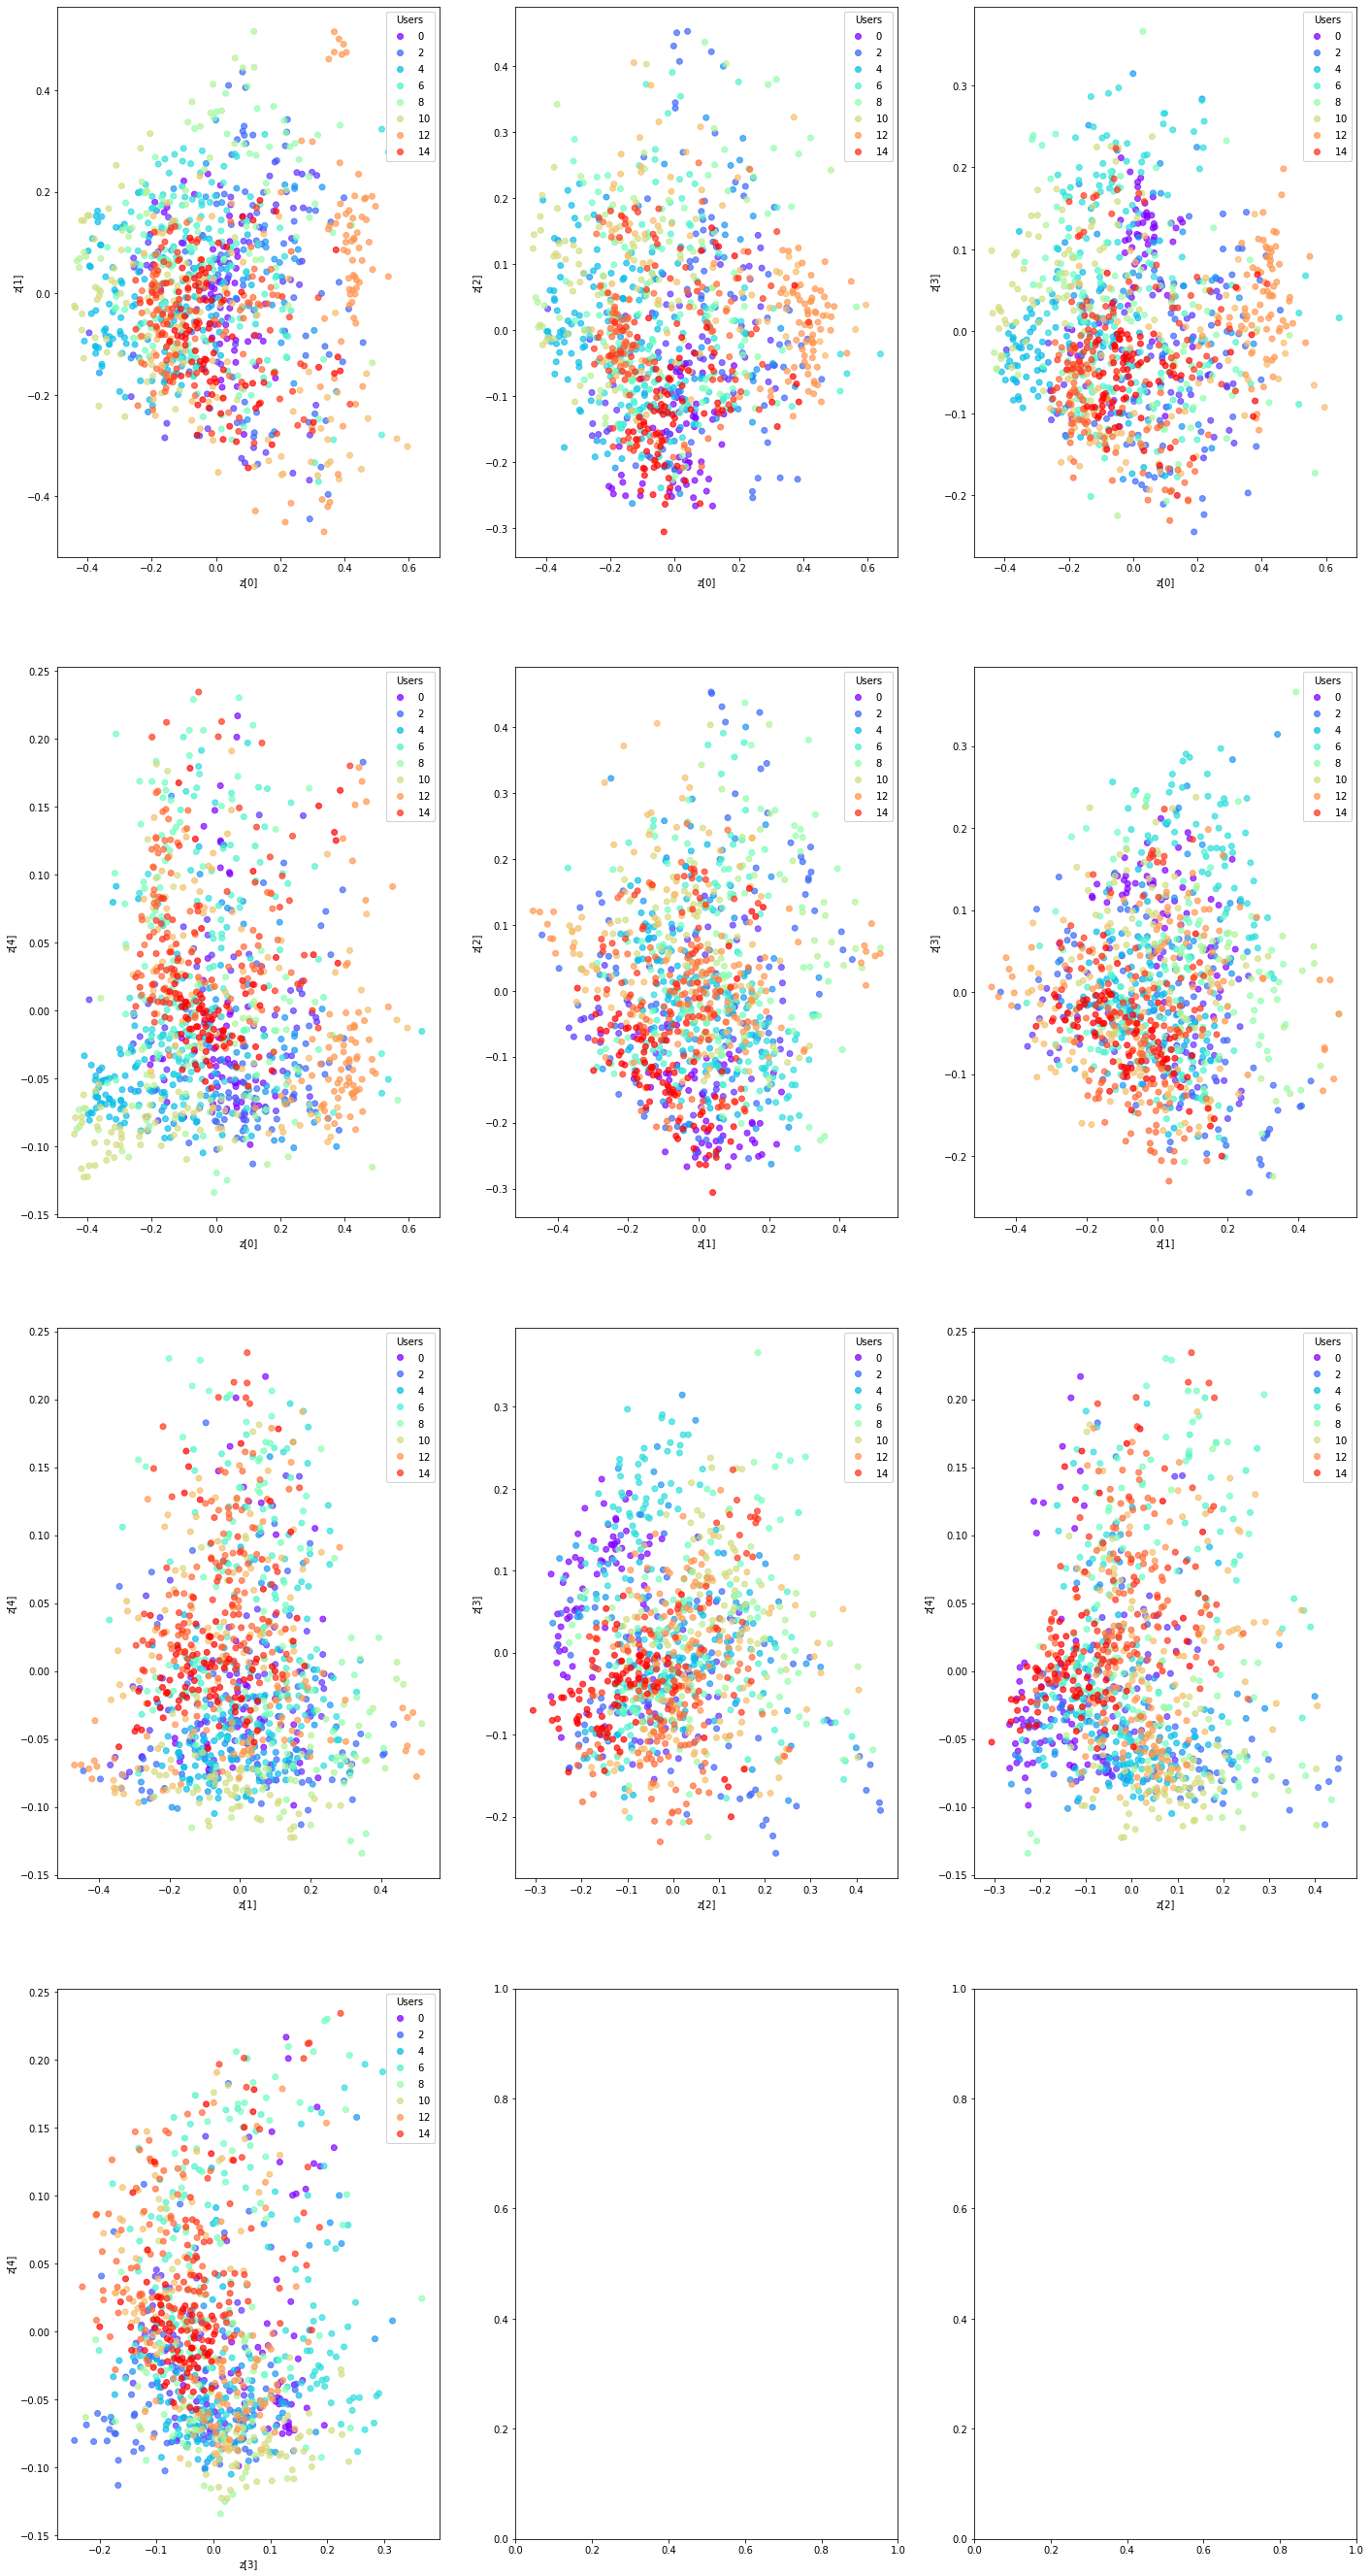

34/34 [==============================] - 0s 2ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


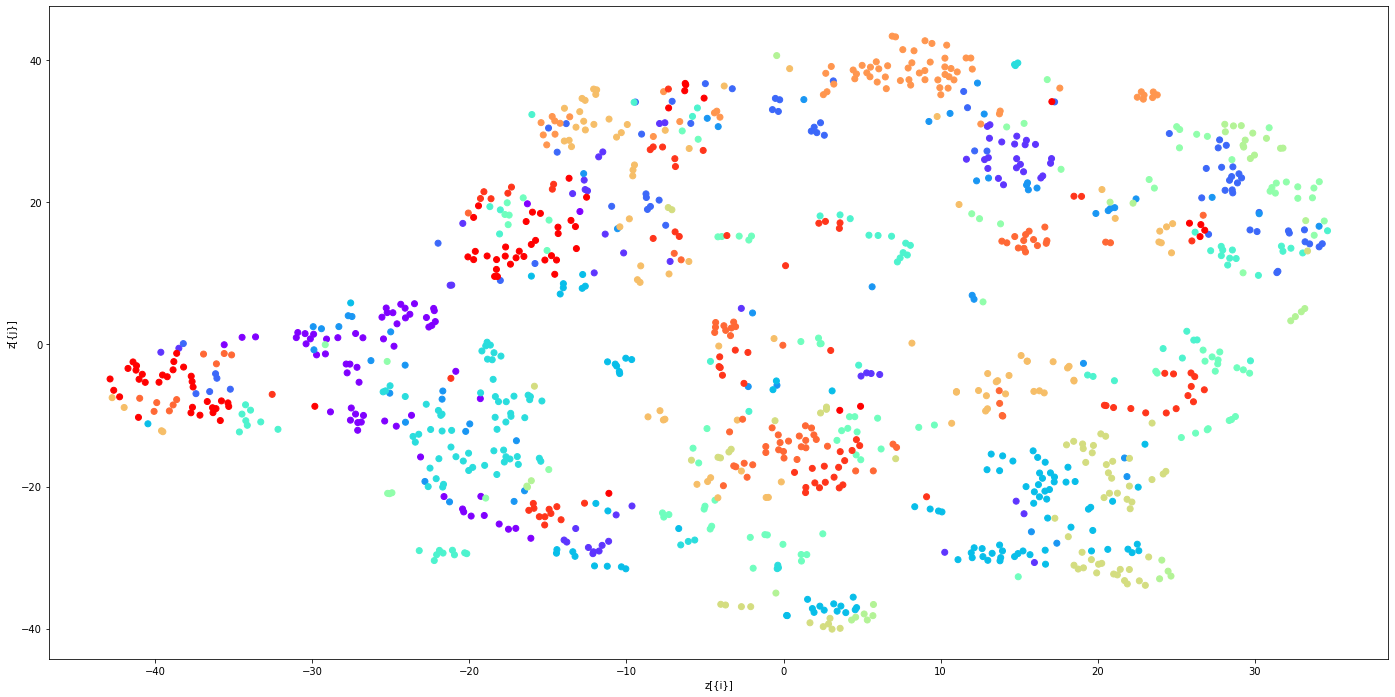

1/1 [==============================] - 0s 22ms/step


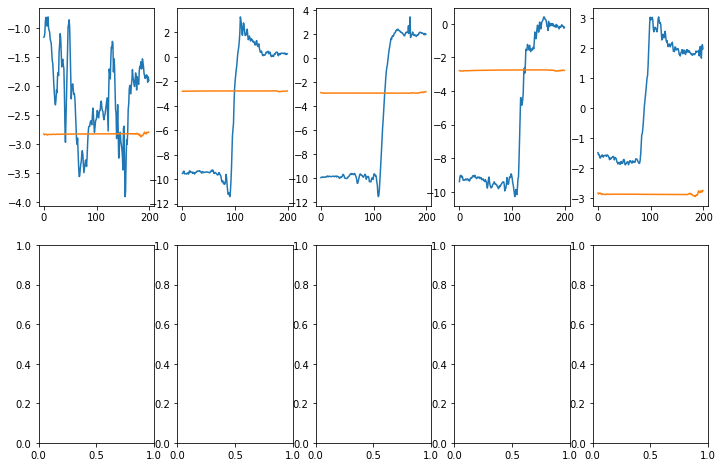

In [8]:
from VAE import Sampling, VAE, get_auth_model_from_latent_space, get_decoder, get_encoder
from visualise import *

latent_dim = 100
encoder = get_encoder(x_data.shape[1:], latent_dim)

decoder = get_decoder(latent_dim)

auth = get_auth_model_from_latent_space(latent_dim)

vae = VAE(encoder, decoder, None, auth)
vae.fit_scaler(x_data[(y_intent==0)])

user_x = vae.scaler.transform(user_x)

opt = keras.optimizers.Adam()

vae.compile(optimizer=opt)

plot_label_clusters(vae, user_x, user_y)
visualise(vae, user_x, user_y)
plot_reconstructed_curves(vae, user_x)

In [9]:
auth_user = 0

vae.auth_on = False

initial_map = ((y_user.argmax(axis=1) != auth_user) & (train_gesture_map==1)) | (y_intent == 0)
initial_map = (train_gesture_map==1) | (y_intent == 0)

train_data = vae.scaler.transform(x_data[initial_map])
opt = keras.optimizers.Adam()

vae.compile(optimizer=opt)
vae.beta = 0.000001
history_1 = vae.fit(train_data, y_user[initial_map], epochs=10, batch_size=128)

#vae.save_model(f"no_{auth_user}", f"basic_reconstruction_{latent_dim}")







Epoch 1/10
260/260 [==============================] - 20s 47ms/step - loss: 0.8138 - reconstruction_loss: 0.6873 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.1337 - kl_loss: 101.8612
Epoch 2/10
260/260 [==============================] - 12s 45ms/step - loss: 0.6189 - reconstruction_loss: 0.5890 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.1345 - kl_loss: 229.1751
Epoch 3/10
260/260 [==============================] - 11s 44ms/step - loss: 0.5886 - reconstruction_loss: 0.5783 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.1327 - kl_loss: 282.8536
Epoch 4/10
260/260 [==============================] - 12s 45ms/step - loss: 0.5535 - reconstruction_loss: 0.5647 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.1308 - kl_loss: 316.1067
Epoch 5/10
260/260 [==============================] - 12s 45ms/step - loss: 0.5457 - reconstruction_loss: 0.5549 - classification_loss: 0.00

34/34 [==============================] - 0s 2ms/step


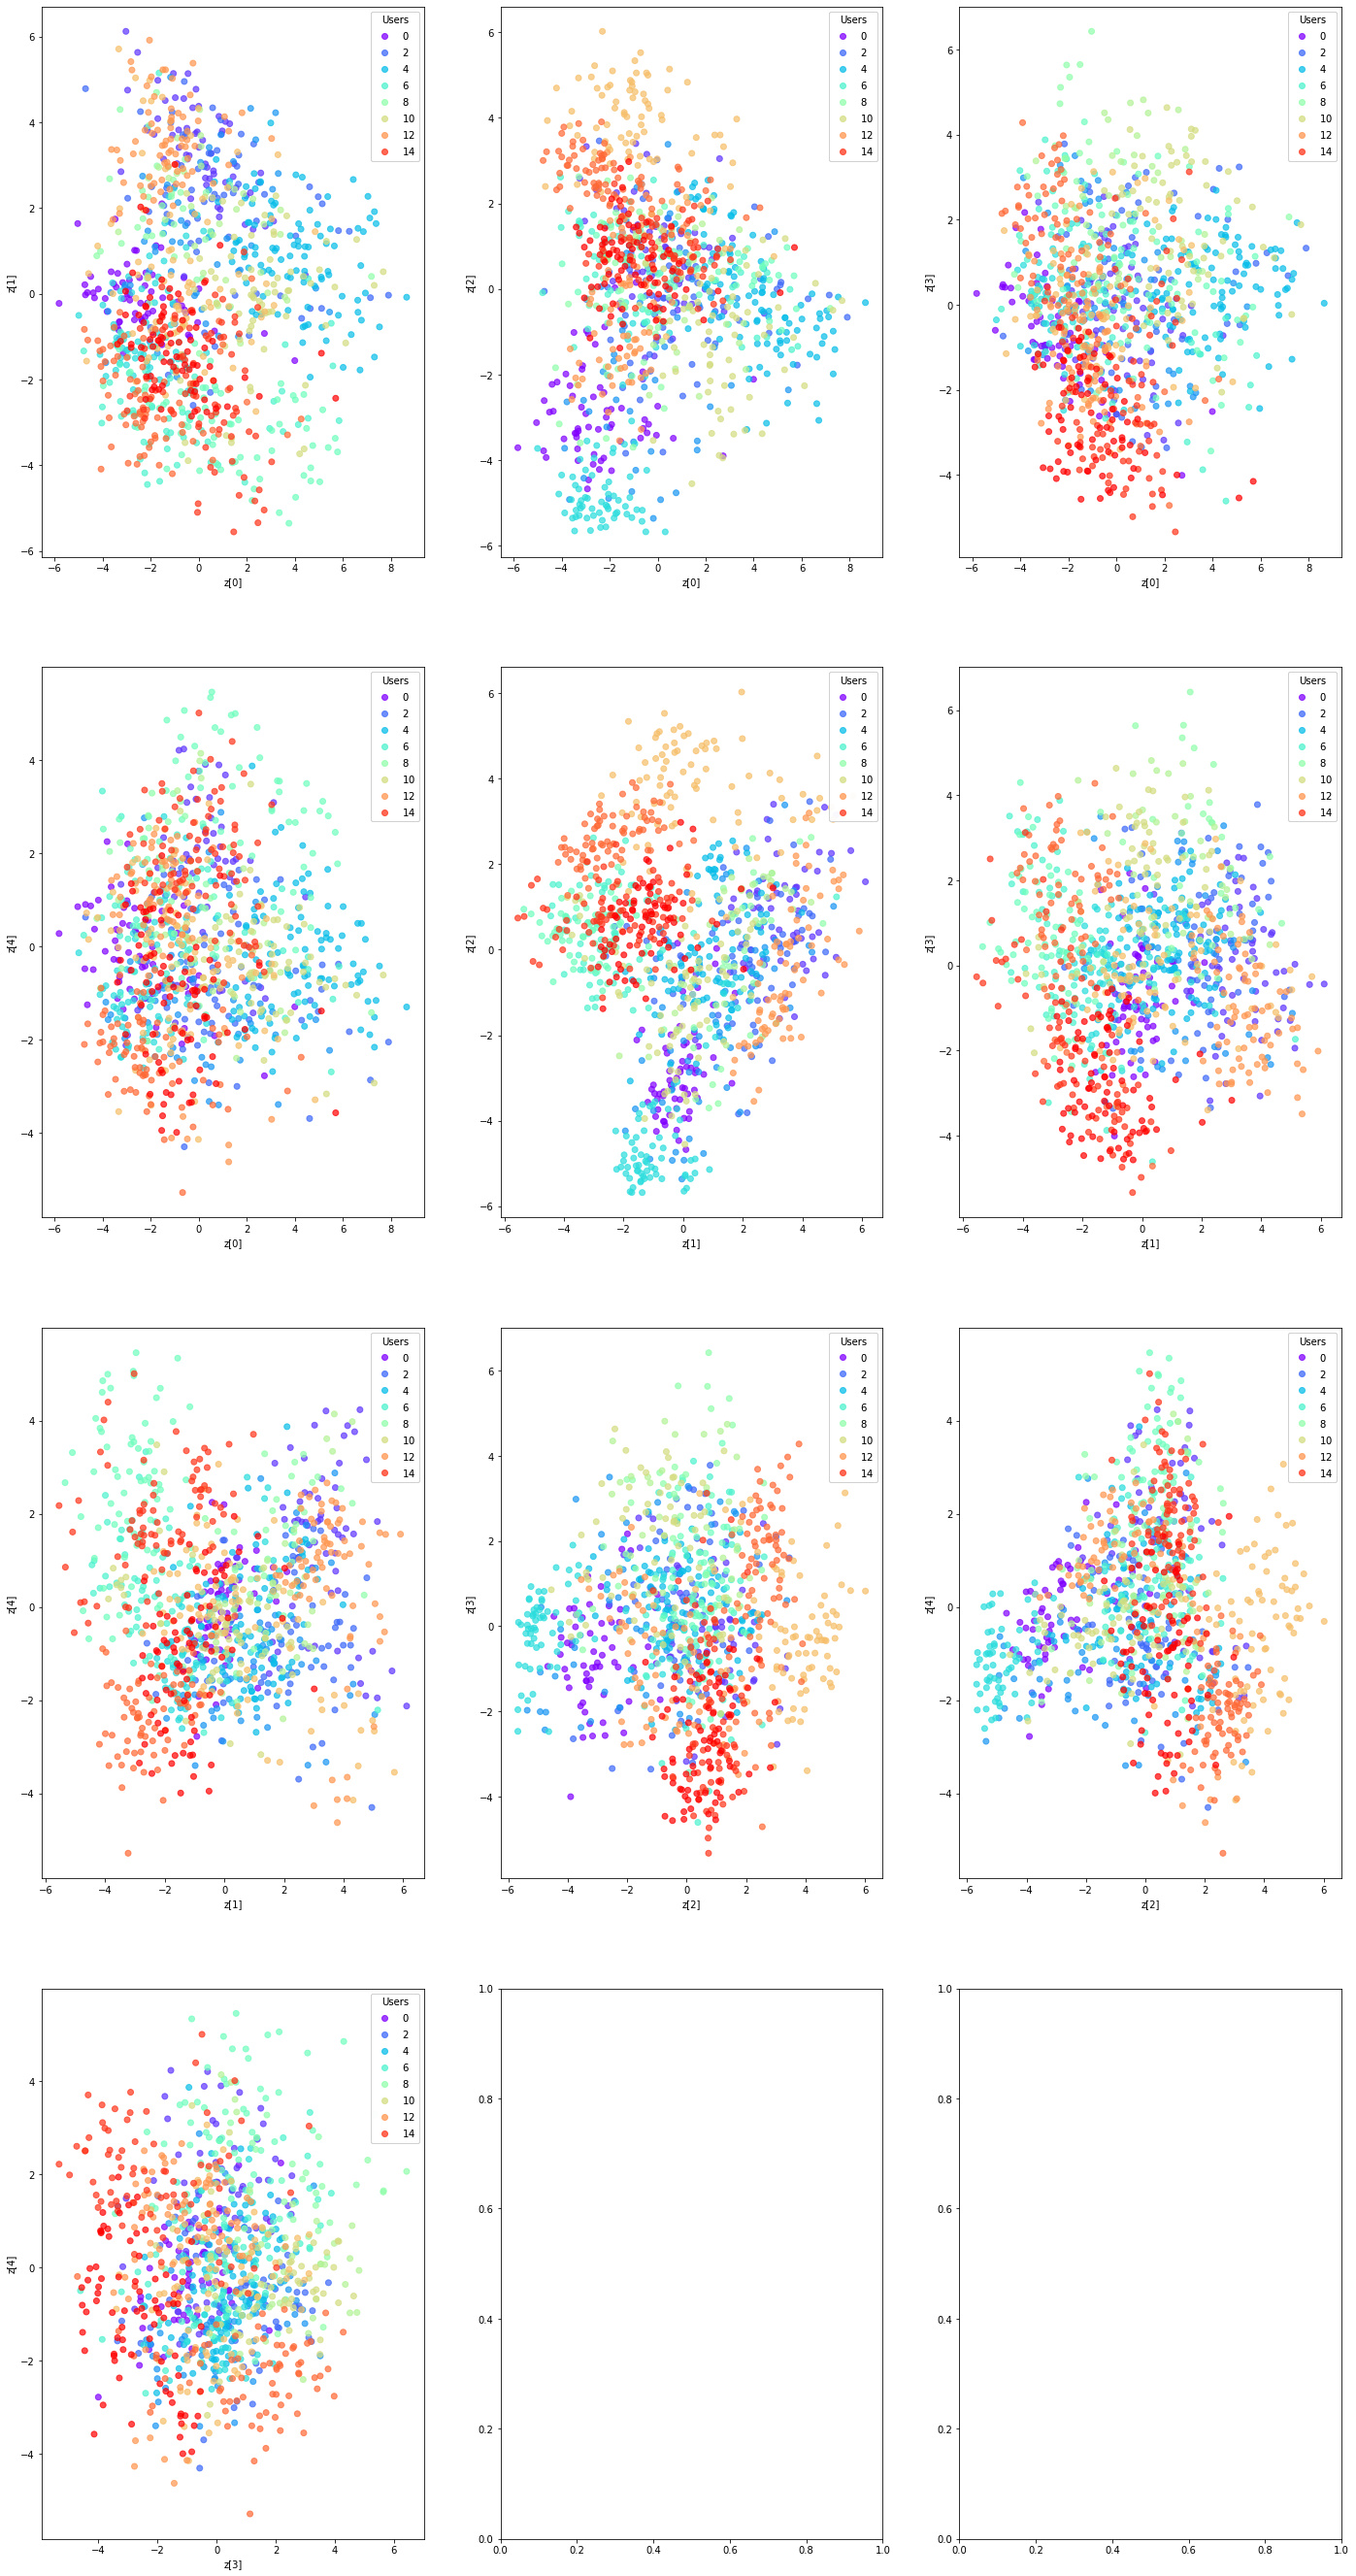

34/34 [==============================] - 0s 3ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


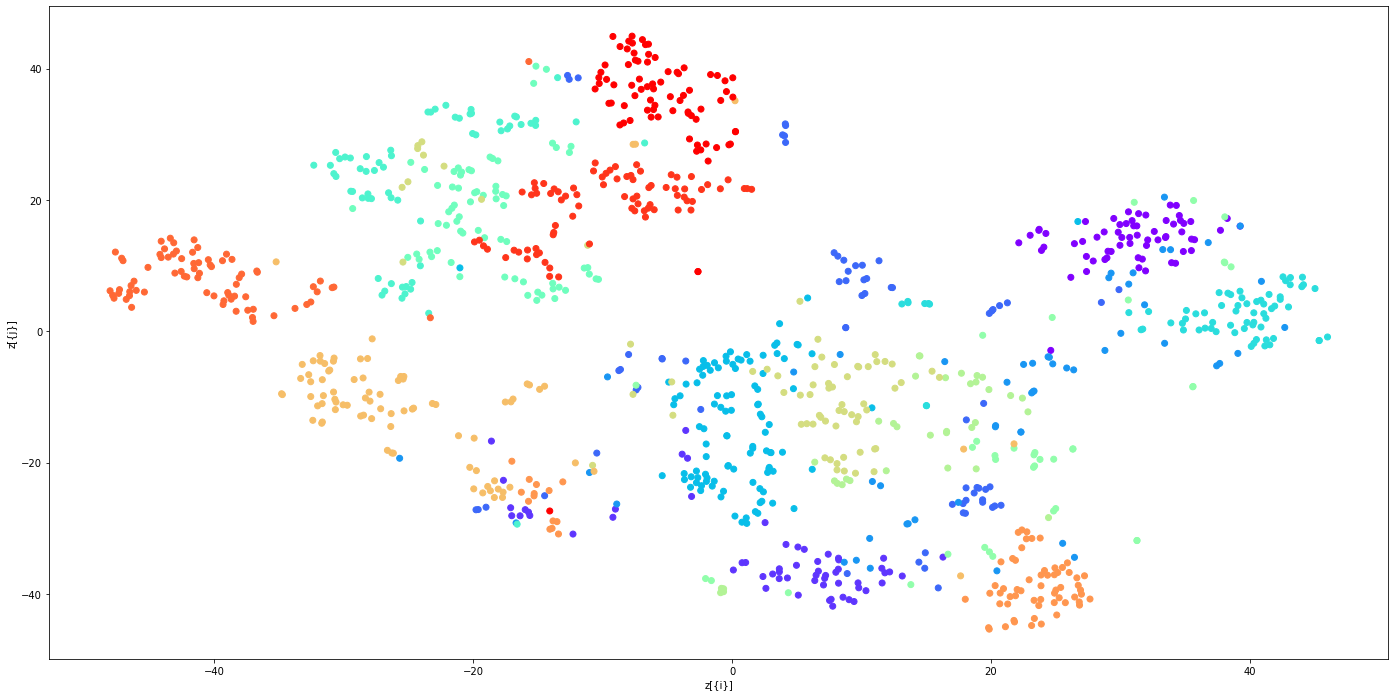

1/1 [==============================] - 0s 19ms/step


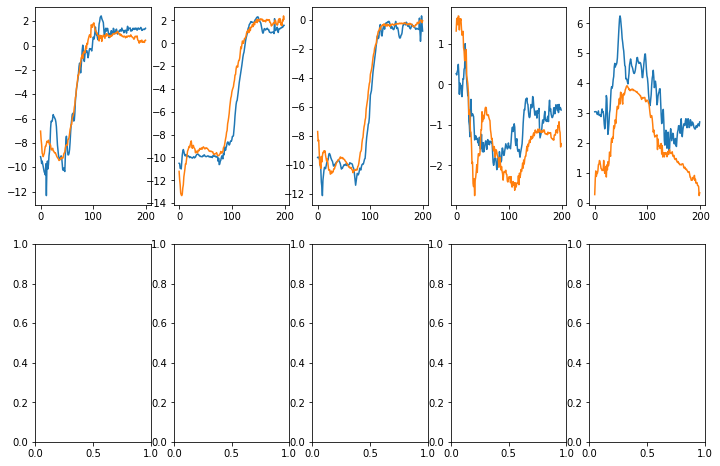

In [18]:
plot_label_clusters(vae, user_x, user_y)
visualise(vae, user_x, user_y)
plot_reconstructed_curves(vae, user_x)

In [17]:
predictions = vae.auth(vae.encoder(user_x)[0]).numpy()
sum(predictions.argmax(axis=1) == user_y) / len(user_y)

0.6866359447004609

In [11]:
### Training without knowing gestures in advance


specific_map = (y_user.argmax(axis=1) != auth_user) & (train_gesture_map==1)  # change with more restricted data in future
specific_map = train_gesture_map == 1

#vae = VAE(None, None, None, None)
#vae.load_model(f"no_{auth_user}", f"basic_reconstruction_{latent_dim}")



Epoch 1/100
19/19 [==============================] - 7s 46ms/step - loss: -0.8062 - reconstruction_loss: 0.1752 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7672 - kl_loss: 143.6616
Epoch 2/100
19/19 [==============================] - 1s 46ms/step - loss: -0.8497 - reconstruction_loss: 0.1384 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7675 - kl_loss: 172.2226
Epoch 3/100
19/19 [==============================] - 1s 46ms/step - loss: -0.8609 - reconstruction_loss: 0.1279 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7678 - kl_loss: 188.6956
Epoch 4/100
19/19 [==============================] - 1s 47ms/step - loss: -0.8567 - reconstruction_loss: 0.1268 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7681 - kl_loss: 202.1349
Epoch 5/100
19/19 [==============================] - 1s 44ms/step - loss: -0.8655 - reconstruction_loss: 0.1237 - classification_loss: 0.0000e+0

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


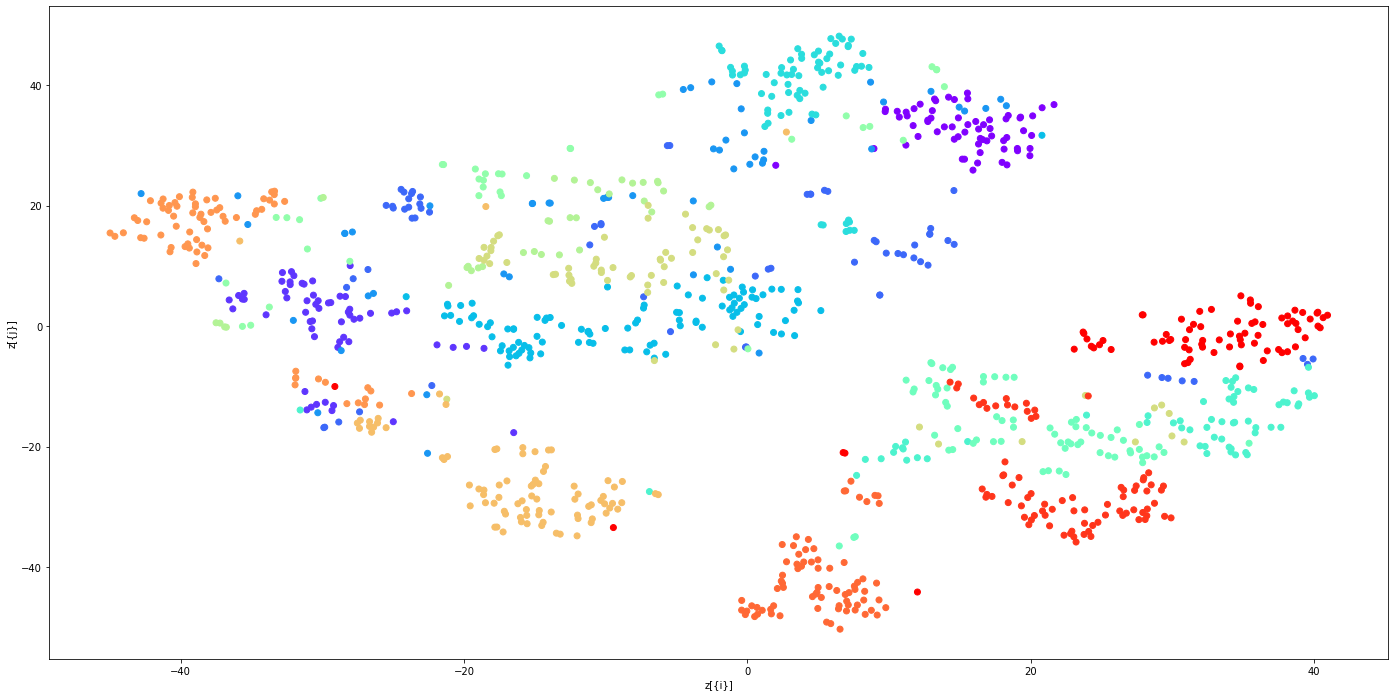

1/1 [==============================] - 0s 20ms/step


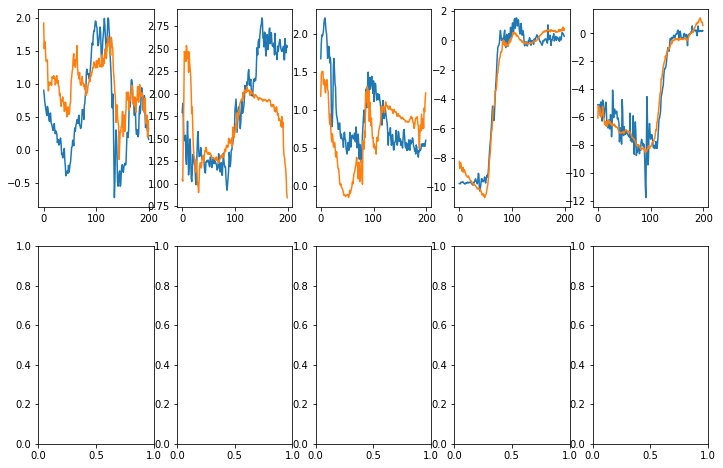

0 1e-06
Epoch 1/50
19/19 [==============================] - 7s 45ms/step - loss: 1.9388 - reconstruction_loss: 1.4669 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7932 - kl_loss: 147.4590
Epoch 2/50
19/19 [==============================] - 1s 43ms/step - loss: 0.4643 - reconstruction_loss: 0.7546 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7926 - kl_loss: 148.0285
Epoch 3/50
19/19 [==============================] - 1s 44ms/step - loss: 0.4059 - reconstruction_loss: 0.6938 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7920 - kl_loss: 155.1694
Epoch 4/50
19/19 [==============================] - 1s 45ms/step - loss: 0.3726 - reconstruction_loss: 0.6649 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7915 - kl_loss: 175.7731
Epoch 5/50
19/19 [==============================] - 1s 47ms/step - loss: 0.3442 - reconstruction_loss: 0.6427 - classification_loss: 0.0000e+00 

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


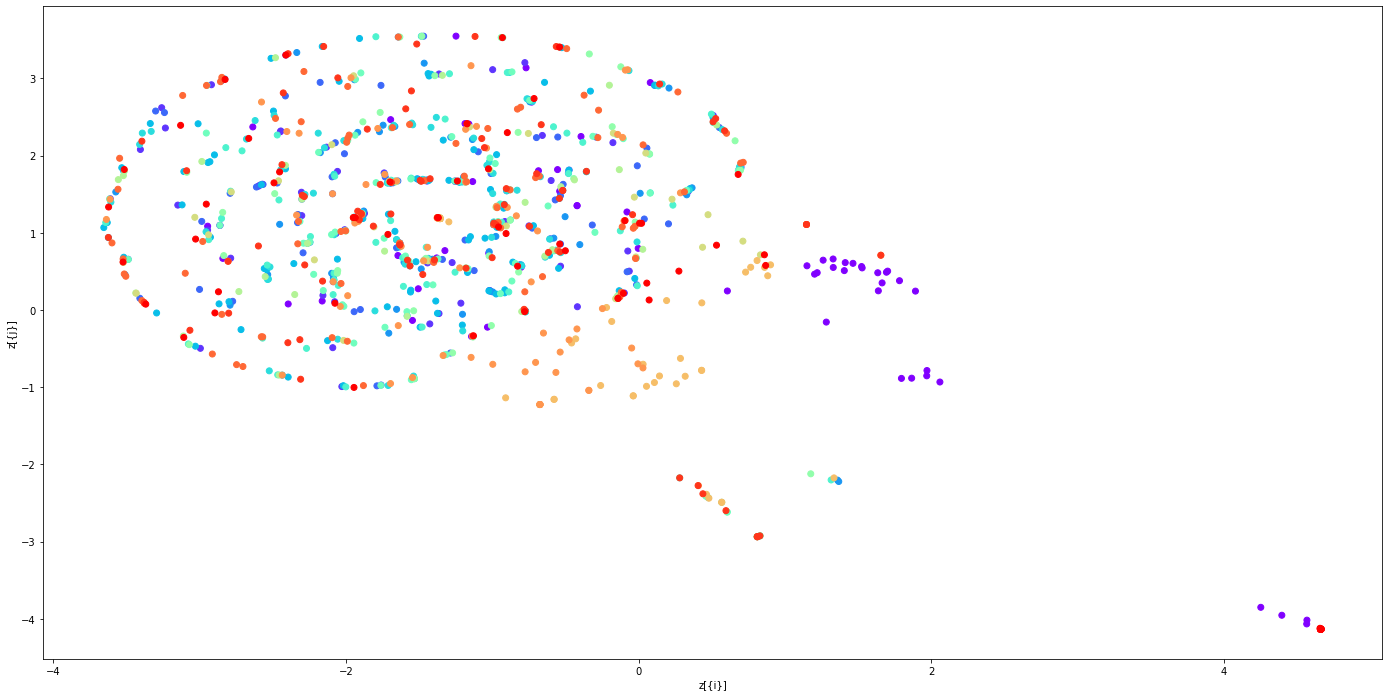

1/1 [==============================] - 0s 19ms/step


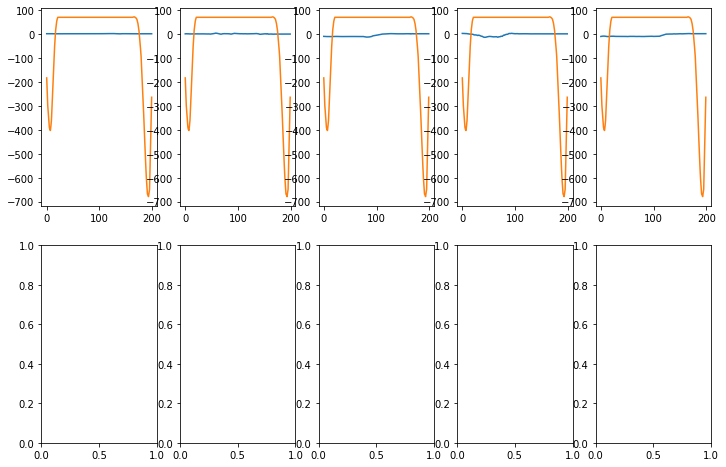

1 1.9952623149688796e-06
Epoch 1/50
19/19 [==============================] - 7s 44ms/step - loss: 18988.4616 - reconstruction_loss: 11477.5547 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7614 - kl_loss: 17463.3691
Epoch 2/50
19/19 [==============================] - 1s 47ms/step - loss: 6744.9061 - reconstruction_loss: 7818.7729 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7608 - kl_loss: 8101.6431
Epoch 3/50
19/19 [==============================] - 1s 47ms/step - loss: 732.7378 - reconstruction_loss: 705.9647 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7601 - kl_loss: 7540.6812
Epoch 4/50
19/19 [==============================] - 1s 46ms/step - loss: 334.7873 - reconstruction_loss: 263.8232 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7594 - kl_loss: 7751.1768
Epoch 5/50
19/19 [==============================] - 1s 48ms/step - loss: 105.1761 - reconstruction_l

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


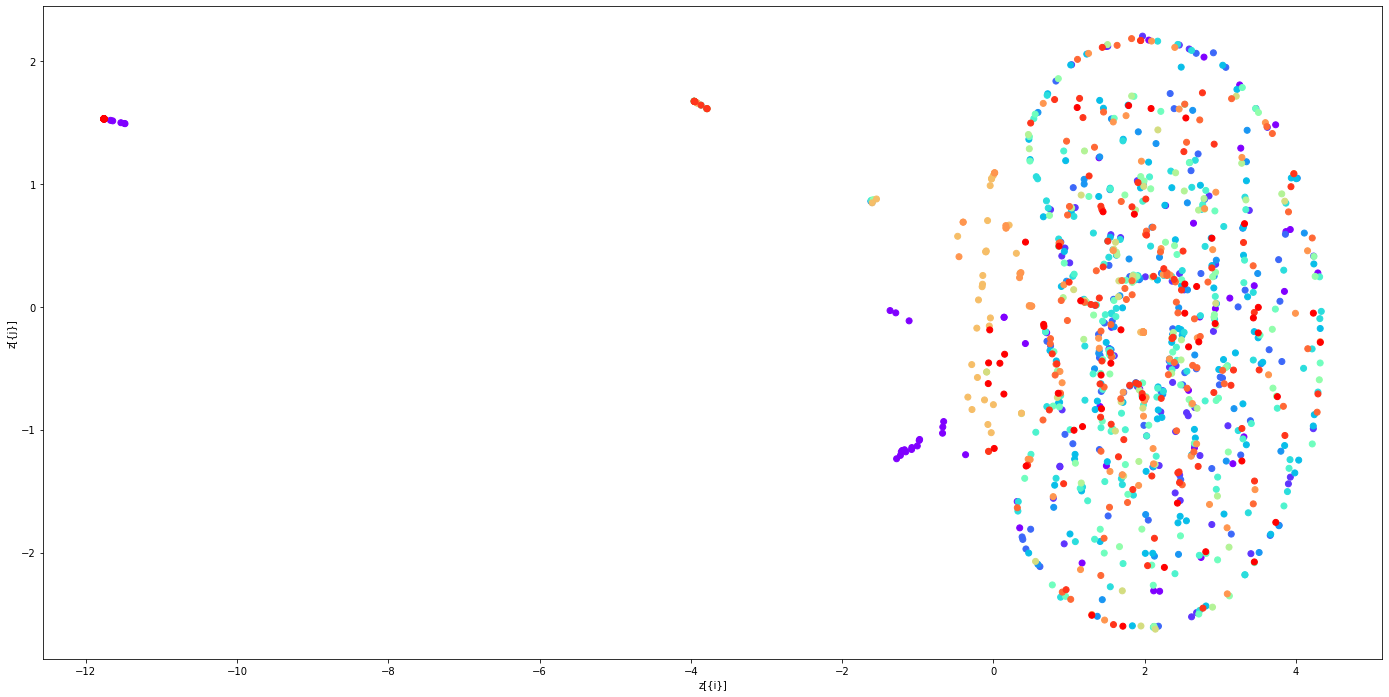

1/1 [==============================] - 0s 20ms/step


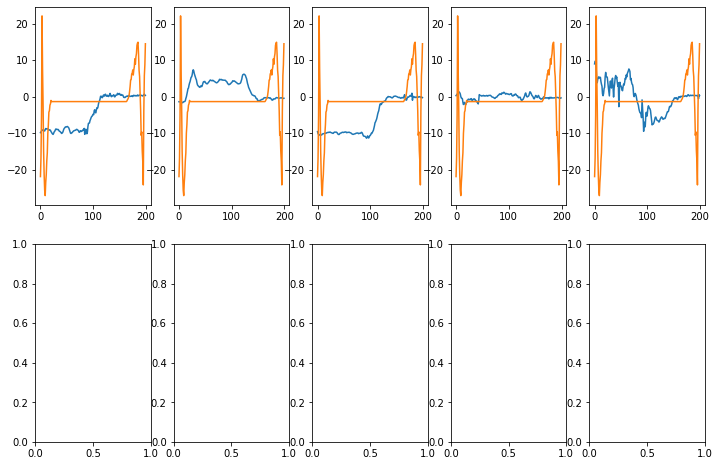

2 3.9810717055349725e-06
Epoch 1/50
19/19 [==============================] - 7s 48ms/step - loss: 6062.3472 - reconstruction_loss: 3332.0767 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7300 - kl_loss: 3362.9983
Epoch 2/50
19/19 [==============================] - 1s 44ms/step - loss: 569.7531 - reconstruction_loss: 476.7701 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7294 - kl_loss: 1254.3533
Epoch 3/50
19/19 [==============================] - 1s 46ms/step - loss: 44.0889 - reconstruction_loss: 35.0349 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7289 - kl_loss: 2097.6780
Epoch 4/50
19/19 [==============================] - 1s 43ms/step - loss: 15.5712 - reconstruction_loss: 13.2123 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7283 - kl_loss: 2598.4595
Epoch 5/50
19/19 [==============================] - 1s 46ms/step - loss: 13.7653 - reconstruction_loss: 10.93

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


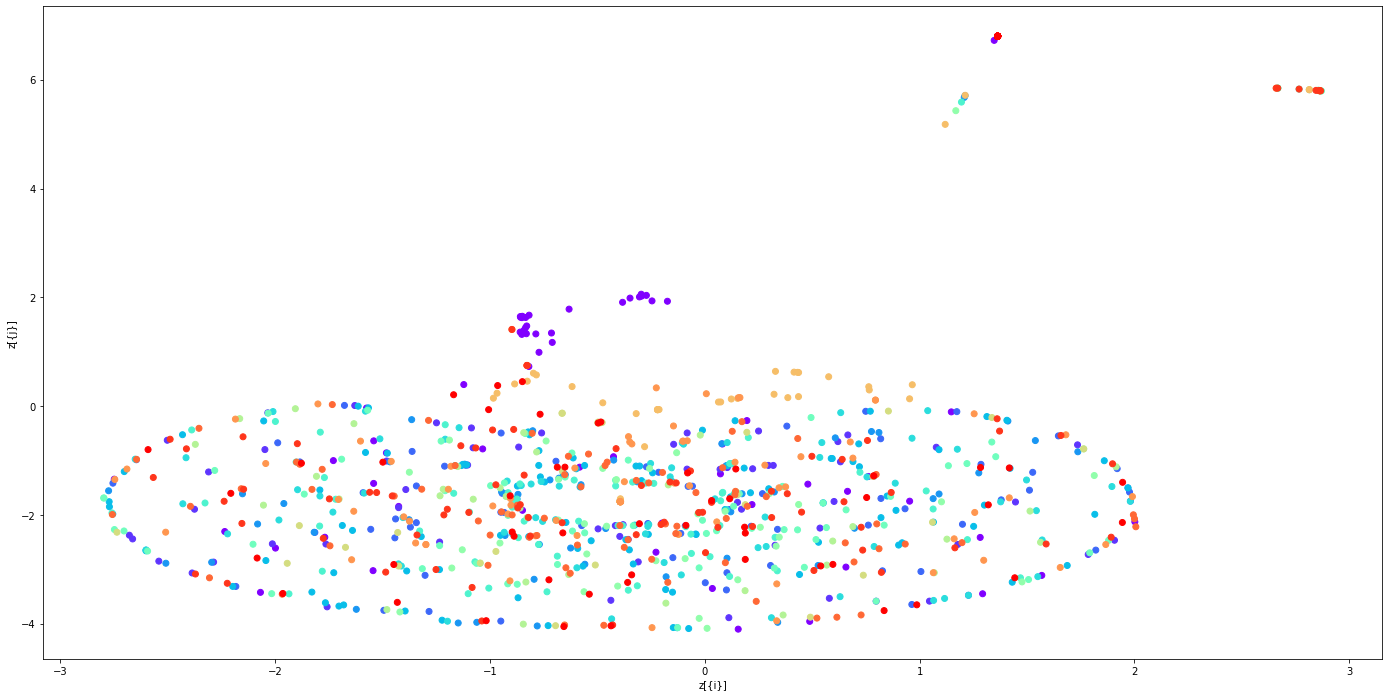

1/1 [==============================] - 0s 20ms/step


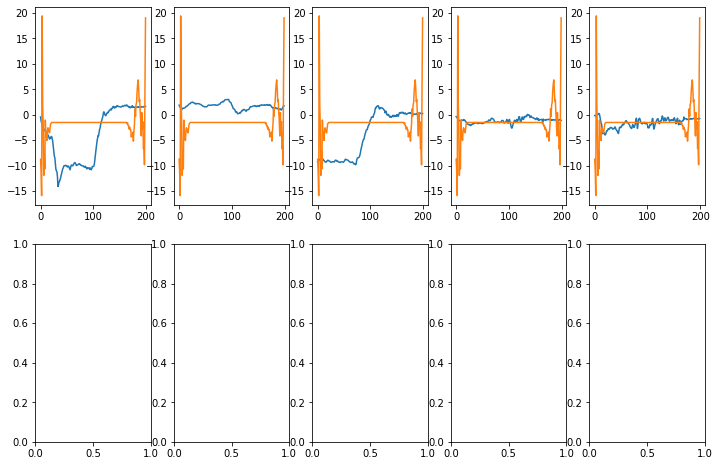

3 7.943282347242815e-06
Epoch 1/50
19/19 [==============================] - 7s 48ms/step - loss: 6166.2344 - reconstruction_loss: 3588.4543 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7023 - kl_loss: 668.6572
Epoch 2/50
19/19 [==============================] - 1s 50ms/step - loss: 535.3183 - reconstruction_loss: 323.8135 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7017 - kl_loss: 172.6164
Epoch 3/50
19/19 [==============================] - 1s 46ms/step - loss: 73.3691 - reconstruction_loss: 50.5884 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7012 - kl_loss: 68.6036
Epoch 4/50
19/19 [==============================] - 1s 45ms/step - loss: 14.3041 - reconstruction_loss: 10.8909 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.7007 - kl_loss: 48.5226
Epoch 5/50
19/19 [==============================] - 1s 45ms/step - loss: 4.8893 - reconstruction_loss: 5.0865 - clas

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


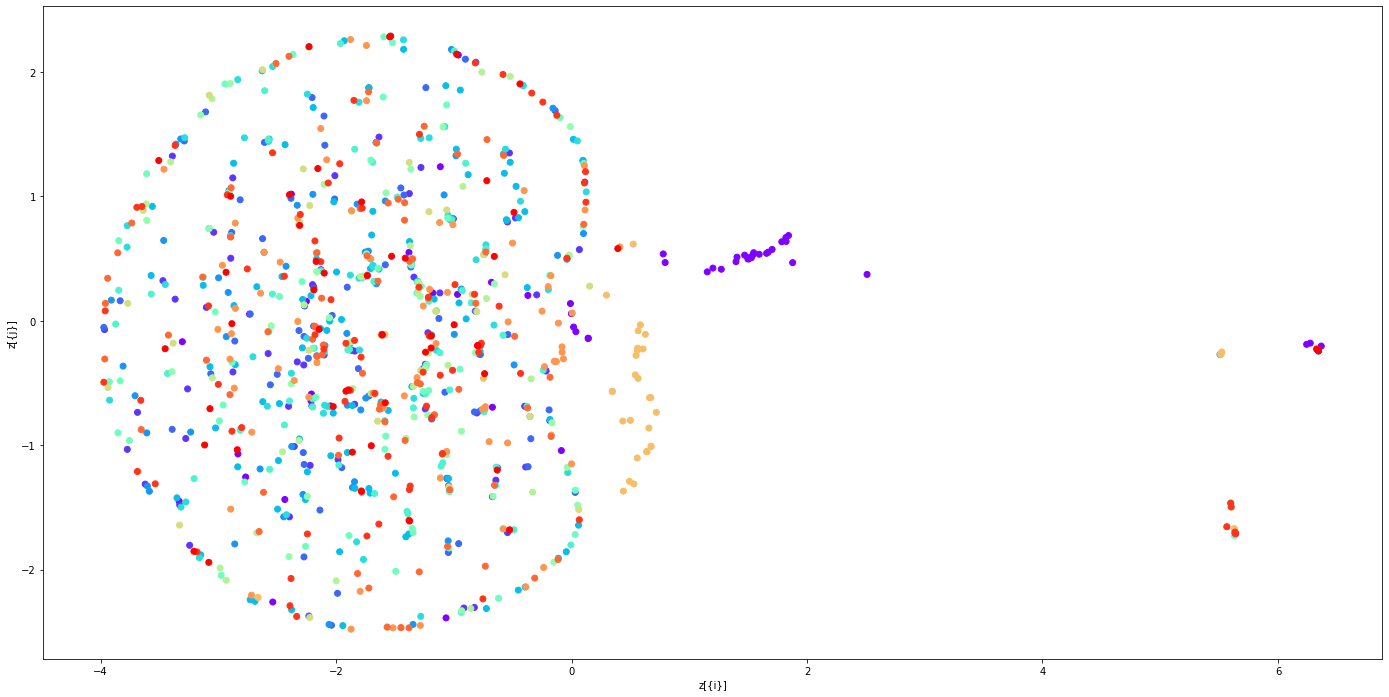

1/1 [==============================] - 0s 21ms/step


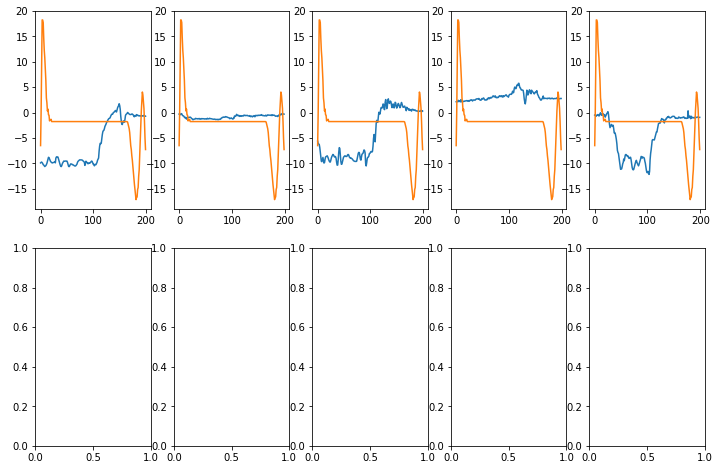

4 1.5848931924611138e-05
Epoch 1/50
19/19 [==============================] - 7s 49ms/step - loss: 252.6195 - reconstruction_loss: 150.1838 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6771 - kl_loss: 29565.2637
Epoch 2/50
19/19 [==============================] - 1s 51ms/step - loss: 15.4226 - reconstruction_loss: 10.9590 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6767 - kl_loss: 14076.5908
Epoch 3/50
19/19 [==============================] - 1s 44ms/step - loss: 3.1431 - reconstruction_loss: 2.5408 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6762 - kl_loss: 13290.1074
Epoch 4/50
19/19 [==============================] - 1s 48ms/step - loss: 1.4209 - reconstruction_loss: 1.3264 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6757 - kl_loss: 13174.8379
Epoch 5/50
19/19 [==============================] - 1s 51ms/step - loss: 1.1105 - reconstruction_loss: 1.0664 - c

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


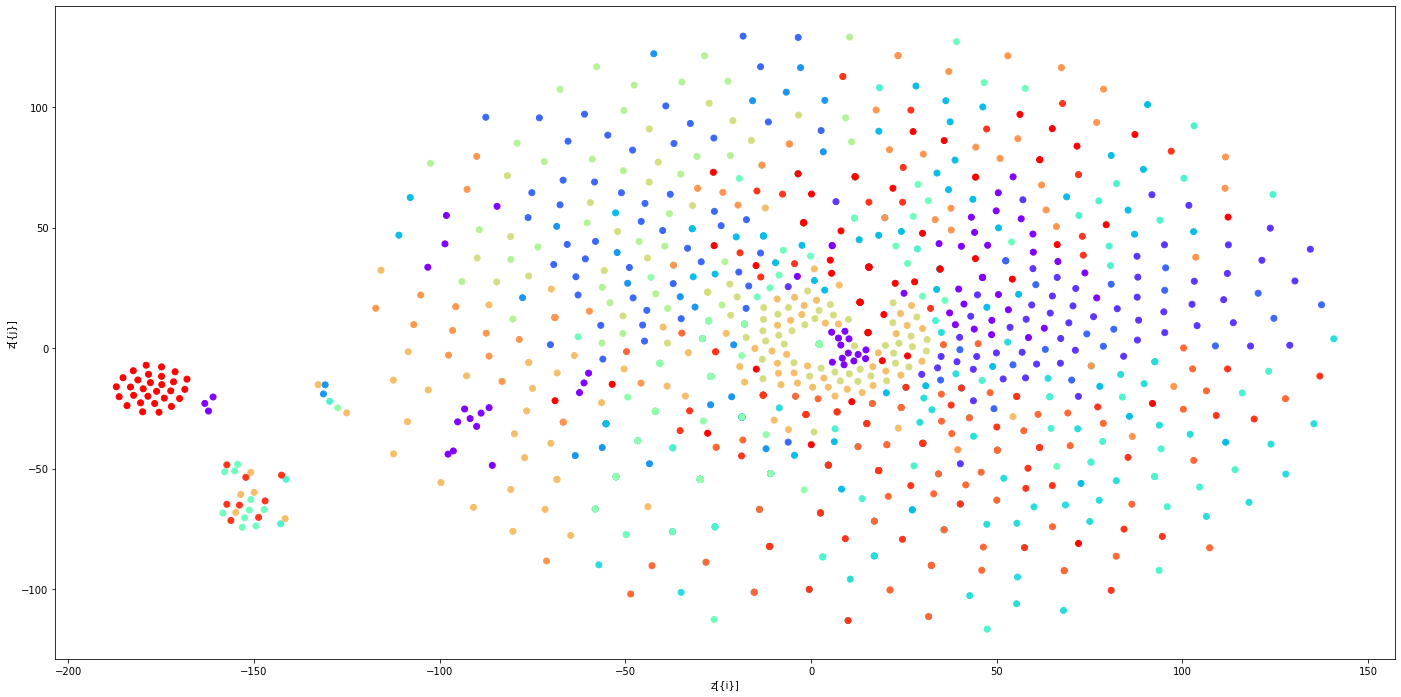

1/1 [==============================] - 0s 21ms/step


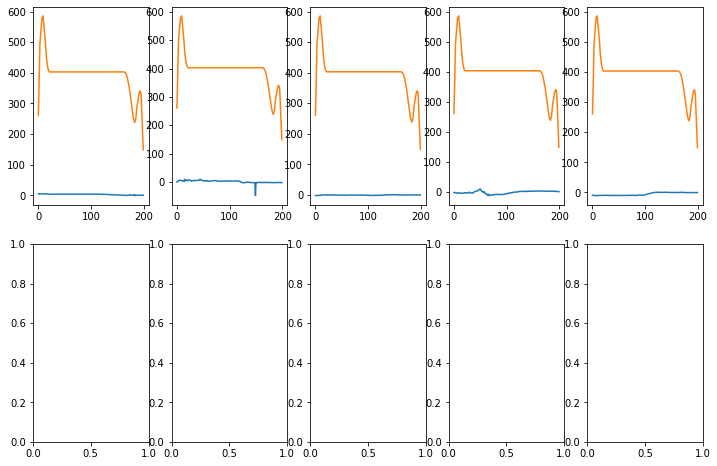

5 3.162277660168379e-05
Epoch 1/50
19/19 [==============================] - 7s 46ms/step - loss: 28798.8200 - reconstruction_loss: 16121.3320 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6543 - kl_loss: 393042.6250
Epoch 2/50
19/19 [==============================] - 1s 46ms/step - loss: 1694.0943 - reconstruction_loss: 935.5676 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6538 - kl_loss: 65316.1562
Epoch 3/50
19/19 [==============================] - 1s 46ms/step - loss: 133.1581 - reconstruction_loss: 105.5249 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6534 - kl_loss: 31022.9766
Epoch 4/50
19/19 [==============================] - 1s 50ms/step - loss: 65.8634 - reconstruction_loss: 43.4584 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6530 - kl_loss: 20915.4844
Epoch 5/50
19/19 [==============================] - 1s 48ms/step - loss: 10.9440 - reconstruction_lo

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


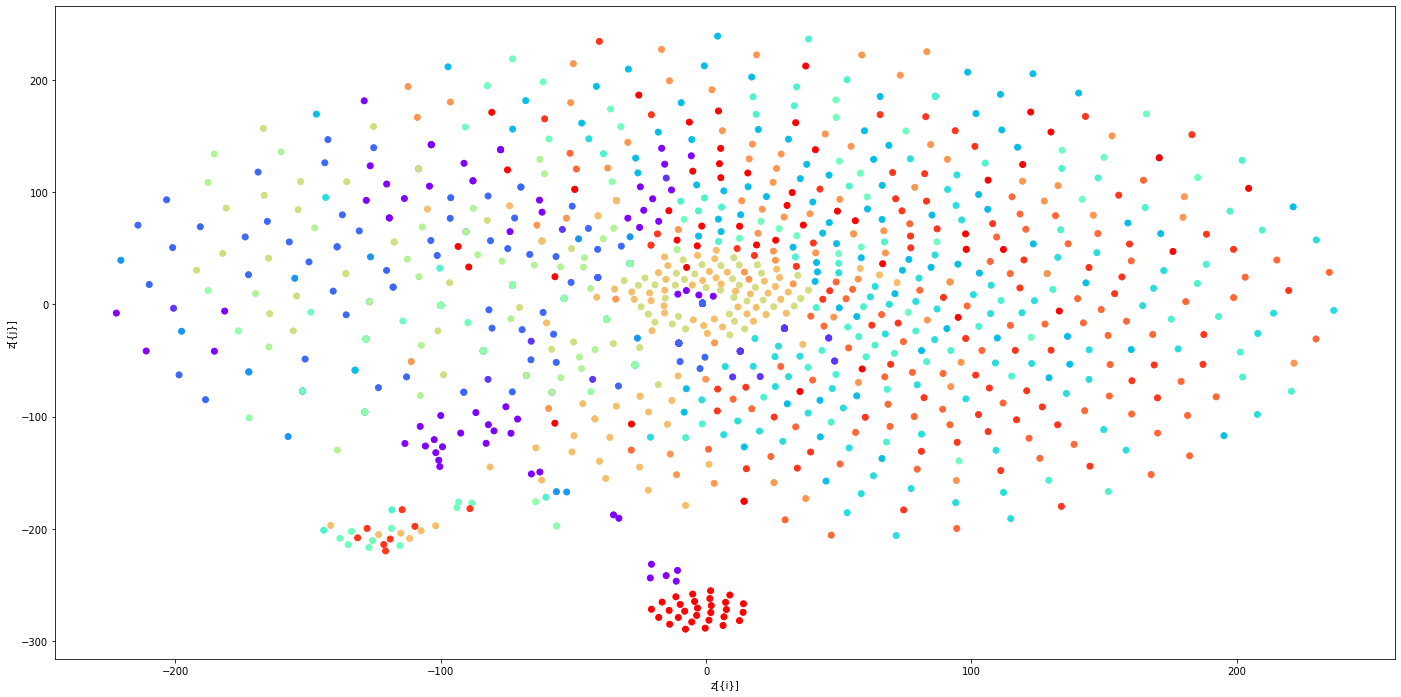

1/1 [==============================] - 0s 20ms/step


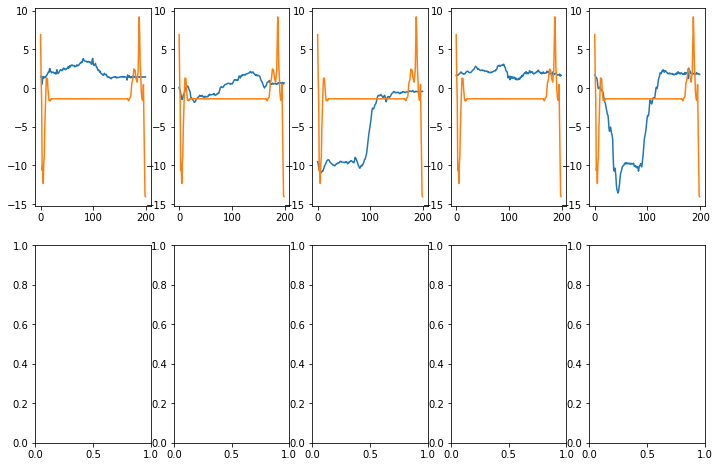

6 6.309573444801929e-05
Epoch 1/50
19/19 [==============================] - 7s 47ms/step - loss: 752.8612 - reconstruction_loss: 446.0427 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6334 - kl_loss: 3879.0588
Epoch 2/50
19/19 [==============================] - 1s 50ms/step - loss: 33.0269 - reconstruction_loss: 23.2880 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6330 - kl_loss: 649.6611
Epoch 3/50
19/19 [==============================] - 1s 45ms/step - loss: 5.5430 - reconstruction_loss: 4.2249 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6326 - kl_loss: 328.7265
Epoch 4/50
19/19 [==============================] - 1s 46ms/step - loss: 1.8008 - reconstruction_loss: 1.6932 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6322 - kl_loss: 263.3095
Epoch 5/50
19/19 [==============================] - 1s 50ms/step - loss: 0.9891 - reconstruction_loss: 1.1214 - classific

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


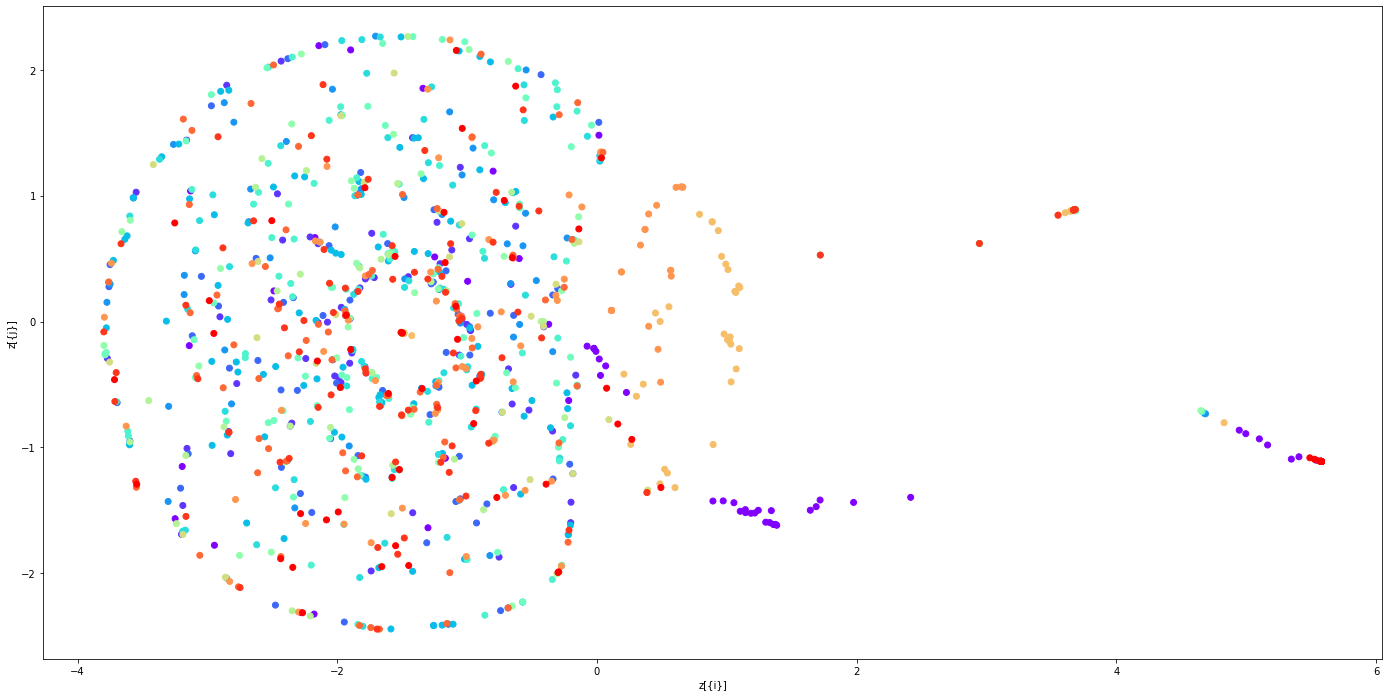

1/1 [==============================] - 0s 20ms/step


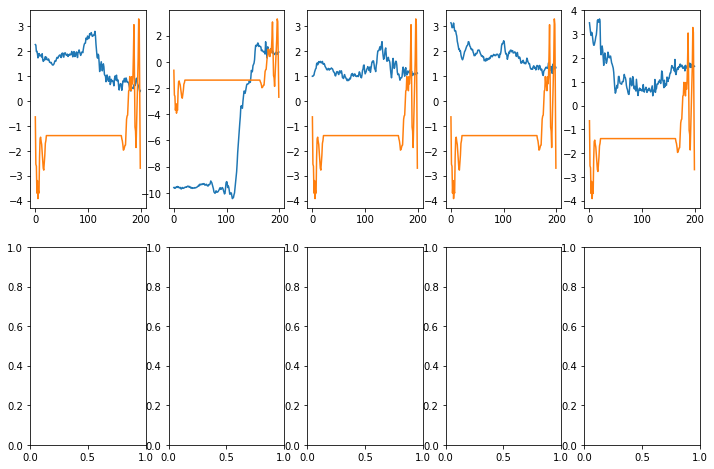

7 0.00012589254117941666
Epoch 1/50
19/19 [==============================] - 7s 49ms/step - loss: 61.7654 - reconstruction_loss: 39.8602 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6144 - kl_loss: 439.5010
Epoch 2/50
19/19 [==============================] - 1s 51ms/step - loss: 5.3765 - reconstruction_loss: 3.5642 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6140 - kl_loss: 40.6643
Epoch 3/50
19/19 [==============================] - 1s 46ms/step - loss: 1.3298 - reconstruction_loss: 1.1990 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6136 - kl_loss: 37.3649
Epoch 4/50
19/19 [==============================] - 1s 49ms/step - loss: 0.7085 - reconstruction_loss: 0.8540 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6133 - kl_loss: 84.4967
Epoch 5/50
19/19 [==============================] - 1s 47ms/step - loss: 0.6557 - reconstruction_loss: 0.7965 - classification_l

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


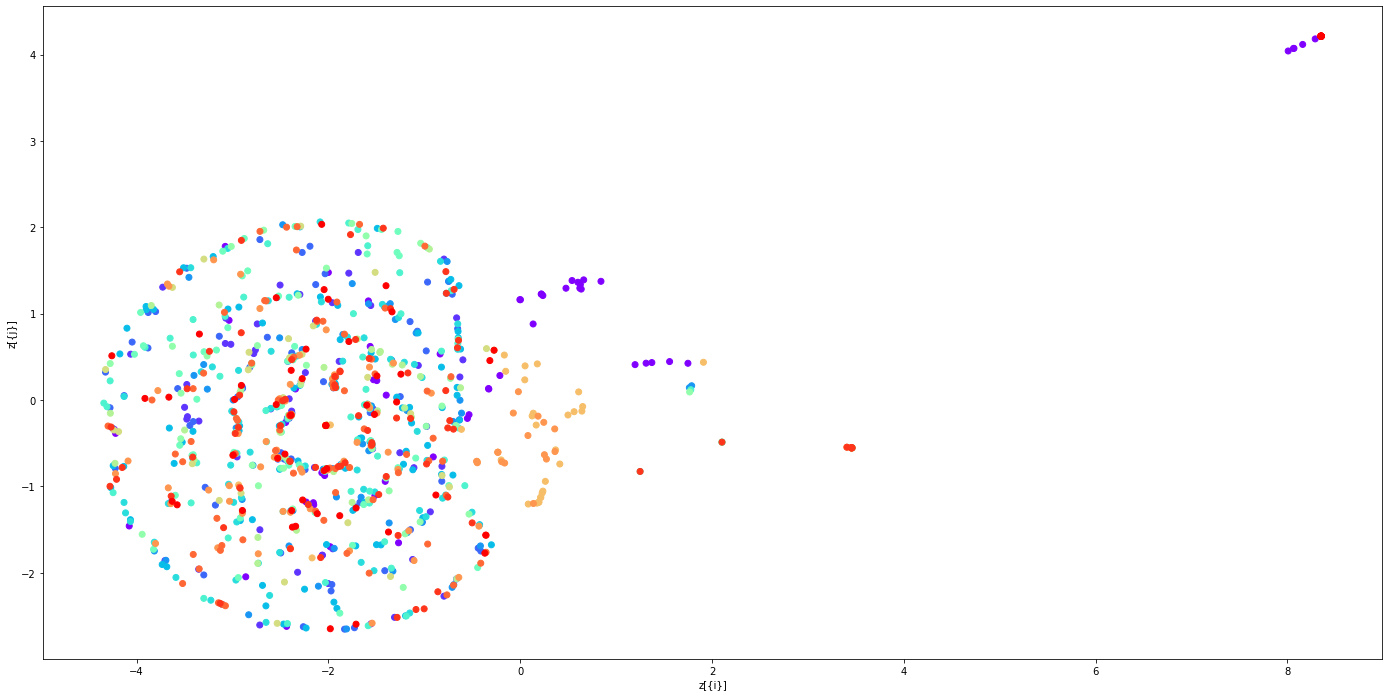

1/1 [==============================] - 0s 23ms/step


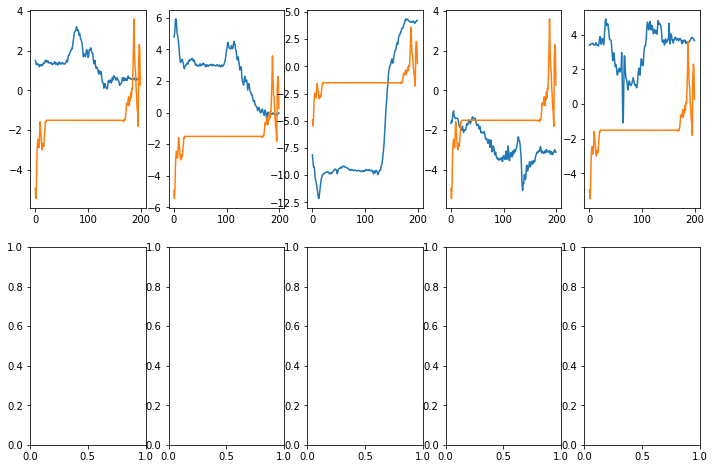

8 0.00025118864315095806
Epoch 1/50
19/19 [==============================] - 7s 46ms/step - loss: 117.2421 - reconstruction_loss: 55.7309 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.5968 - kl_loss: 299.7724
Epoch 2/50
19/19 [==============================] - 1s 45ms/step - loss: 4.8518 - reconstruction_loss: 3.8458 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.5965 - kl_loss: 26.6253
Epoch 3/50
19/19 [==============================] - 1s 45ms/step - loss: 2.0833 - reconstruction_loss: 2.0076 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.5962 - kl_loss: 33.7492
Epoch 4/50
19/19 [==============================] - 1s 47ms/step - loss: 0.9463 - reconstruction_loss: 1.0601 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.5958 - kl_loss: 88.9728
Epoch 5/50
19/19 [==============================] - 1s 46ms/step - loss: 0.8072 - reconstruction_loss: 0.9382 - classification_

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


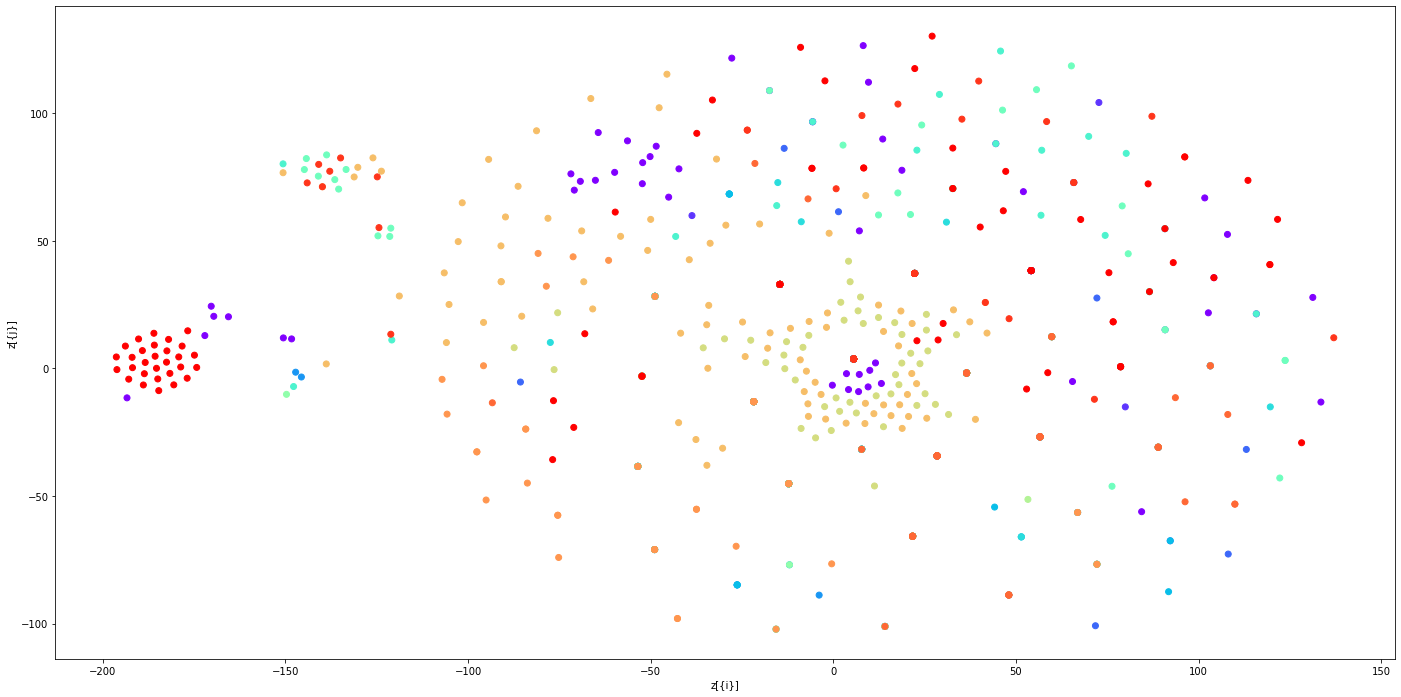

1/1 [==============================] - 0s 22ms/step


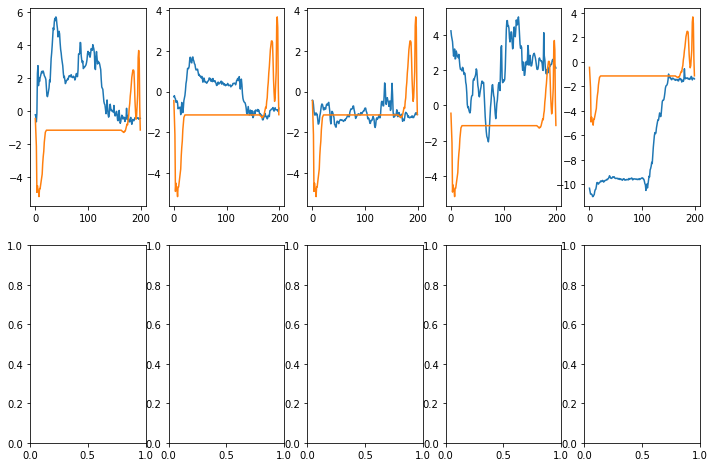

9 0.0005011872336272722
Epoch 1/50
19/19 [==============================] - 7s 45ms/step - loss: 27.1855 - reconstruction_loss: 14.9212 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.5807 - kl_loss: 217.2228
Epoch 2/50
19/19 [==============================] - 1s 46ms/step - loss: 2.0595 - reconstruction_loss: 1.7242 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.5804 - kl_loss: 18.7411
Epoch 3/50
19/19 [==============================] - 1s 49ms/step - loss: 0.8737 - reconstruction_loss: 0.9615 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.5801 - kl_loss: 47.4291
Epoch 4/50
19/19 [==============================] - 1s 50ms/step - loss: 0.7086 - reconstruction_loss: 0.8460 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.5798 - kl_loss: 52.5197
Epoch 5/50
19/19 [==============================] - 1s 47ms/step - loss: 0.6567 - reconstruction_loss: 0.8147 - classification_lo

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


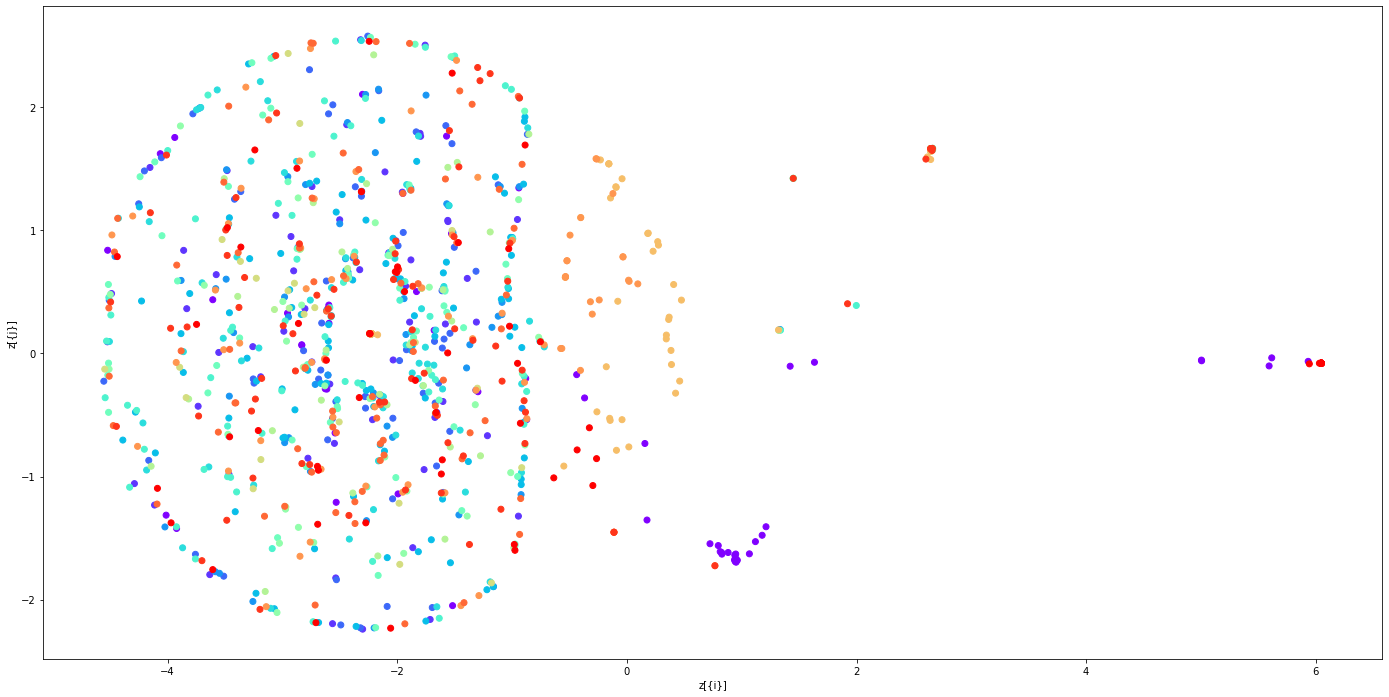

1/1 [==============================] - 0s 20ms/step


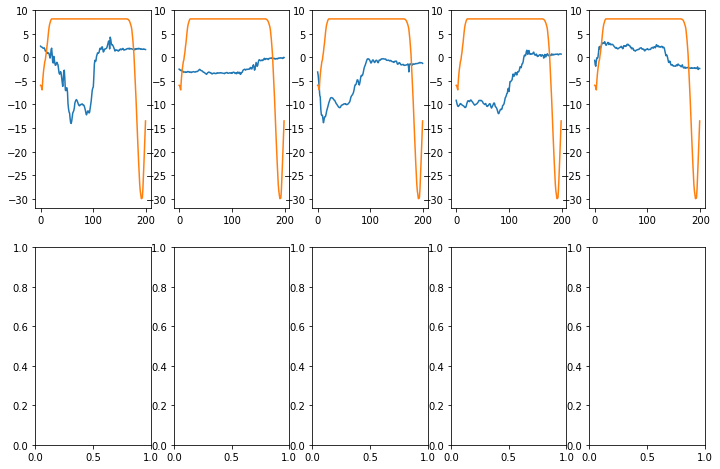

In [19]:
beta = 0.000001 #0.00001

epochs = 10

vae.beta = beta
vae.auth_on = True

vae.compile(keras.optimizers.Adam())


train_data = vae.scaler.transform(x_data[specific_map])

vae.fit(train_data, y_user[specific_map], epochs=100, batch_size=128)
visualise(vae, user_x, user_y)
plot_reconstructed_curves(vae, train_data)

for epoch in range(epochs):
    beta_star = beta / np.exp(-epoch * np.log(1000) / epochs)
    print(epoch, beta_star)
    vae.beta = beta_star
    vae.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01))

    vae.fit(train_data, y_user[specific_map], epochs=50, batch_size=128)
    
    visualise(vae, user_x, user_y)
    plot_reconstructed_curves(vae, user_x)


#vae.save_model(f"no_{auth_user}", f"trained_without_user")

1/1 [==============================] - 0s 32ms/step


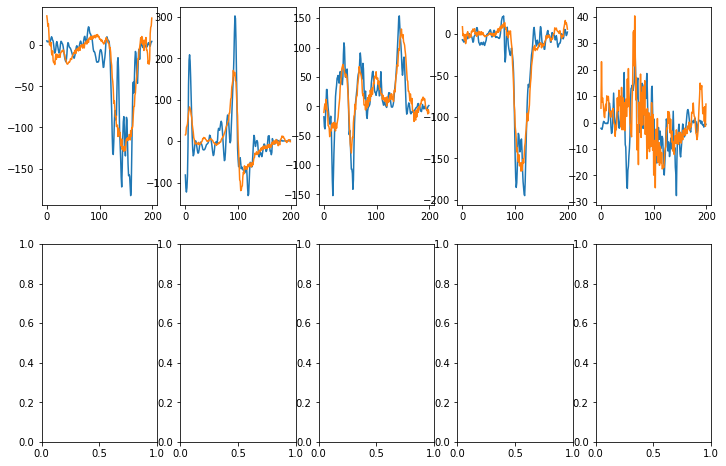

In [44]:
fig,ax = plt.subplots(2,5, figsize=(12,8))
j = 0

data = x_data[y_intent==1] # vae.scaler.transform(
channel = 4

for i in random.sample(range(0, len(data)), 5):
    enc = vae.encoder.predict(vae.scaler.transform(data[i:i+1])) #vae.scaler.transform(
    dec = vae.scaler.inverse_transform(vae.decoder.predict(enc[2])) #  
    ax[divmod(j,5)].plot(data[i,:,channel], label="original")
    ax[divmod(j,5)].plot(dec[0,:,channel], label="reconstructed")

    j += 1
plt.show()


In [ ]:
vae.load_model(f"no_{auth_user}", f"trained_without_user")

In [15]:
pca = PCA(5)
total_z_mean, _, _ = vae.encoder.predict(scaler.transform(x_data[specific_map]))
total_z_pca = pca.fit_transform(total_z_mean)

71/71 [==============================] - 4s 4ms/step


In [16]:
from sklearn.manifold import TSNE
import pandas as pd

def dimension_reduction(z_pca, labels) -> pd.DataFrame:

    visualisation = TSNE(n_components=2).fit_transform(z_pca)
    df = pd.DataFrame(visualisation, columns = ["dimension 1", "dimension 2"])  #, "dimension 3"
    df["labels"] = labels
    return df

In [17]:
def plot_label_clusters(vae, data, labels, pca=None):
    # display a 2D plot of the user classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    if pca is None:
        pca = PCA()
        z_pca = pca.fit_transform(z_mean)
        #z_pca = z_mean
    else:
        z_pca = pca.transform(z_mean)
    
    comps = 5
    
    #z_pca = z_mean

    pair_set = [(i,j) for i in range(comps) for j in range(i+1,comps)]
    
    fig, ax = plt.subplots(1 + len(pair_set)//3,3, figsize=(24,48))
    
    for ix, (i,j) in enumerate(pair_set):
        scatter = ax[divmod(ix, 3)].scatter(z_pca[:, i], z_pca[:, j], c=labels, alpha=0.7, cmap = "rainbow")
        ax[divmod(ix, 3)].set_xlabel(f"z[{i}]")
        ax[divmod(ix, 3)].set_ylabel(f"z[{j}]")
        legend = ax[divmod(ix, 3)].legend(*scatter.legend_elements(),
                    loc="upper right", title="Users")
        ax[divmod(ix, 3)].add_artist(legend)
    #plt.colorbar()
    
    plt.show()

def visualise(vae, data, labels, pca=None):
    # display a 2D plot of the user classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    if pca is None:
        pca = PCA(20)
        z_pca = pca.fit_transform(z_mean)
        #z_pca = z_mean
    else:
        z_pca = pca.transform(z_mean)
    
    df = dimension_reduction(z_pca, labels)

    fig, ax = plt.subplots(1,1, figsize=(24,12) ) # , subplot_kw={"projection": "3d"})# , 
                           
    ax.scatter(df["dimension 1"], df["dimension 2"], c = df["labels"], cmap = "rainbow") #  df["dimension 3"],
    ax.set_xlabel("z[{i}]")
    ax.set_ylabel("z[{j}]")
    plt.legend()
    #plt.colorbar()
    
    plt.show()

    
# [:len(y_gesture)]
    
intent_x = scaler.transform(np.array(list(x_data[:1000])+list(x_data[-1000:])))
intent_y = np.array(list(y_intent[:1000]) + list(y_intent[-1000:]))

gesture_x = scaler.transform(x_data[:600])
gesture_y = y_gesture.argmax(axis=1)[:600]

_map = (train_gesture_map==1) & ((y_user.argmax(axis=1) == 14) | (y_user.argmax(axis=1) == 7) | (y_user.argmax(axis=1) == 0))

user_x = scaler.transform(x_data[_map])
user_y = y_user.argmax(axis=1)[_map]




15/15 [==============================] - 0s 7ms/step


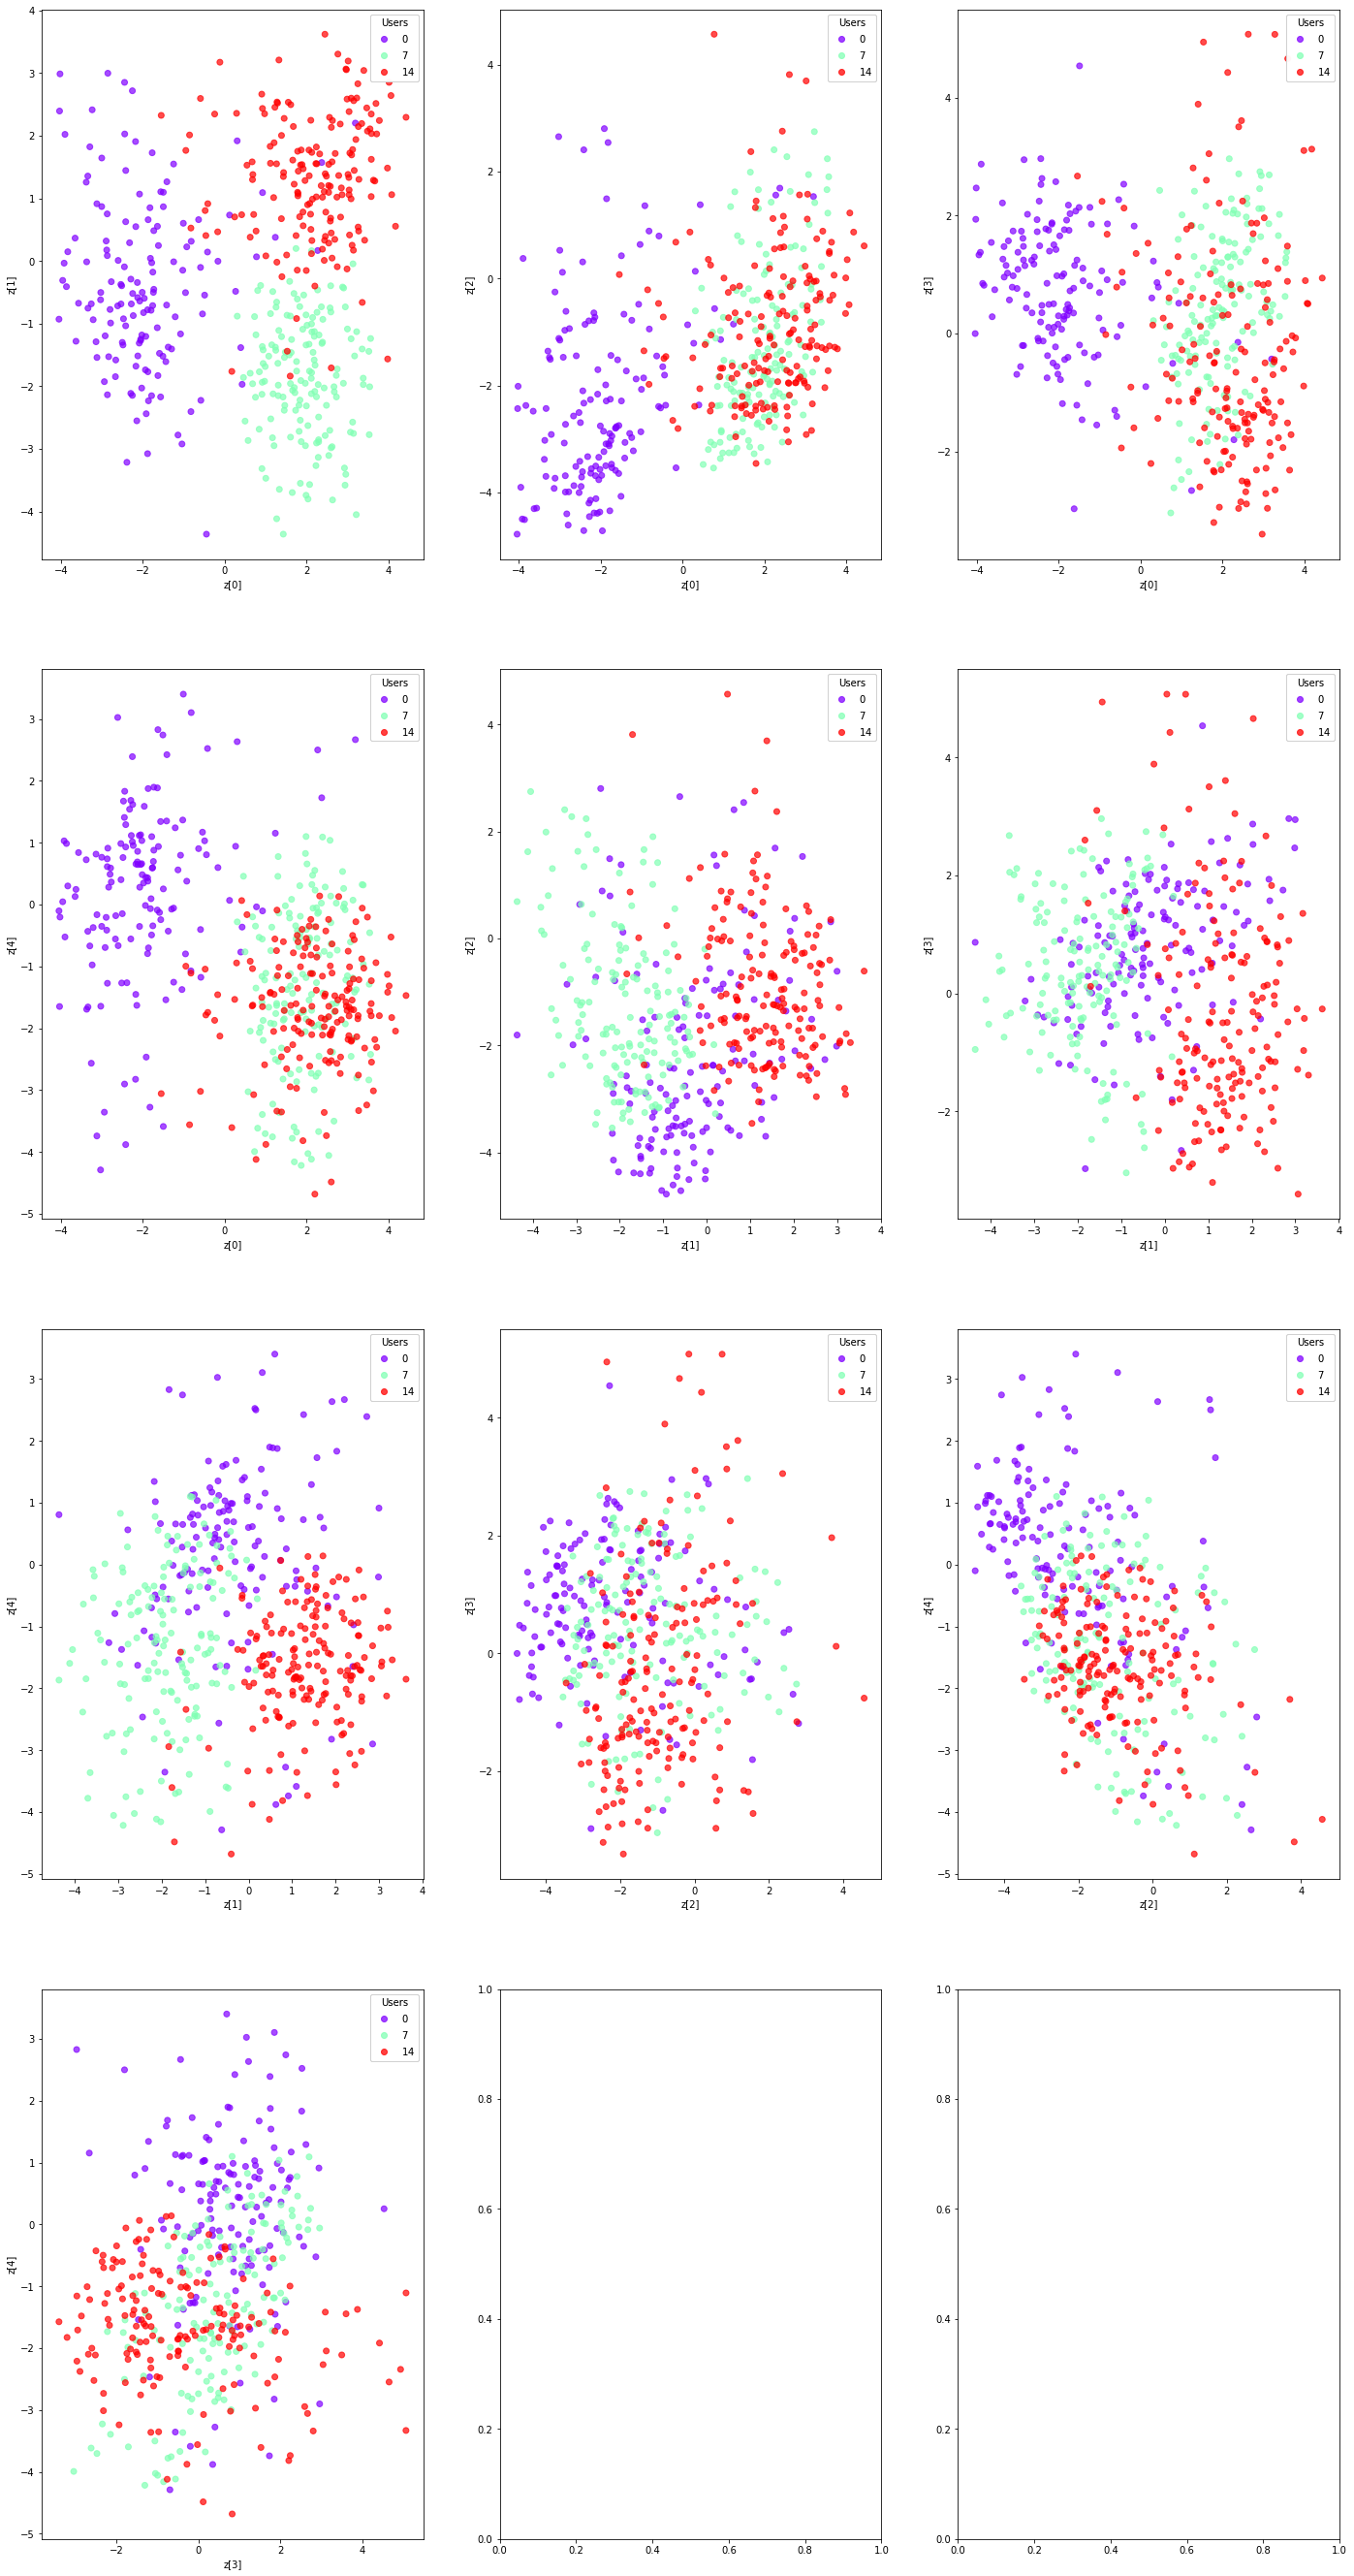

15/15 [==============================] - 0s 3ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


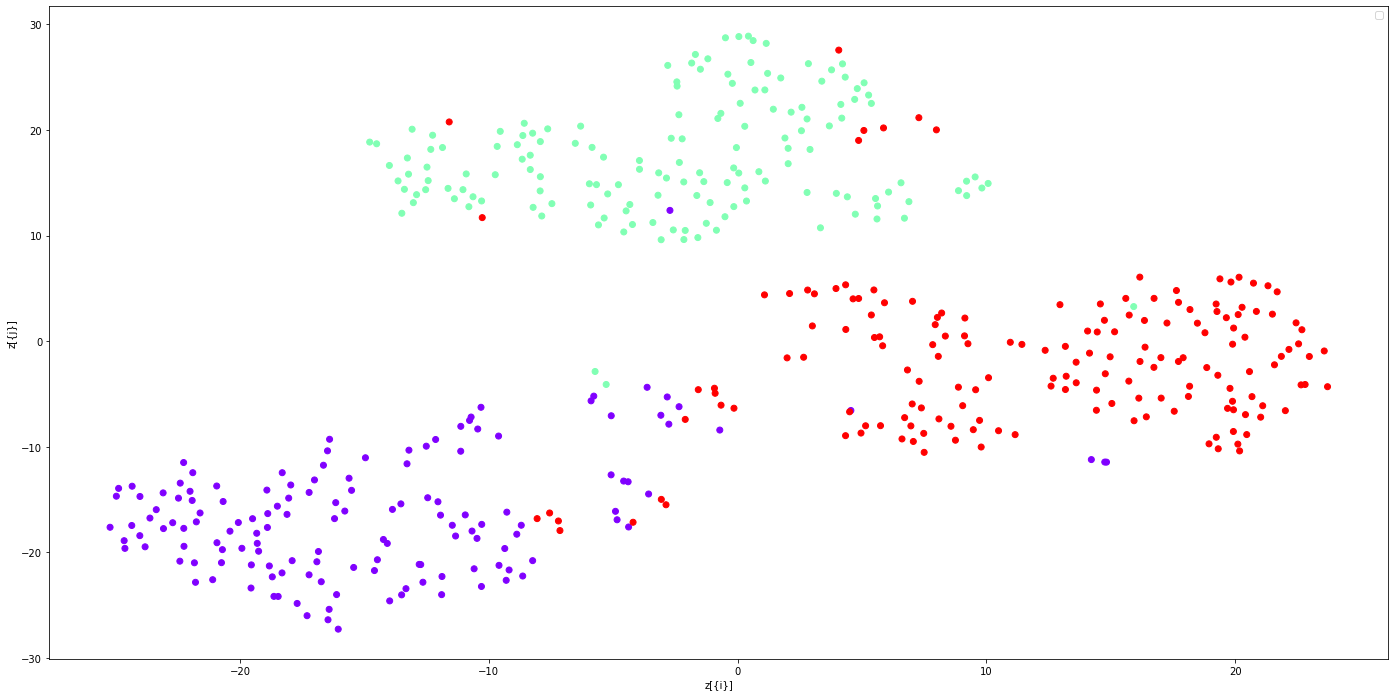

In [18]:
#plot_label_clusters(vae, intent_x, intent_y, pca)
plot_label_clusters(vae, user_x, user_y, pca)
#plot_label_clusters(vae, gesture_x, gesture_y, pca)

visualise(vae, user_x, user_y, pca)
#visualise(vae, intent_x, intent_y)
#visualise(vae, gesture_x, gesture_y, pca)

1/1 [==============================] - 0s 24ms/step
(7, 100)
16/16 [==============================] - 0s 7ms/step


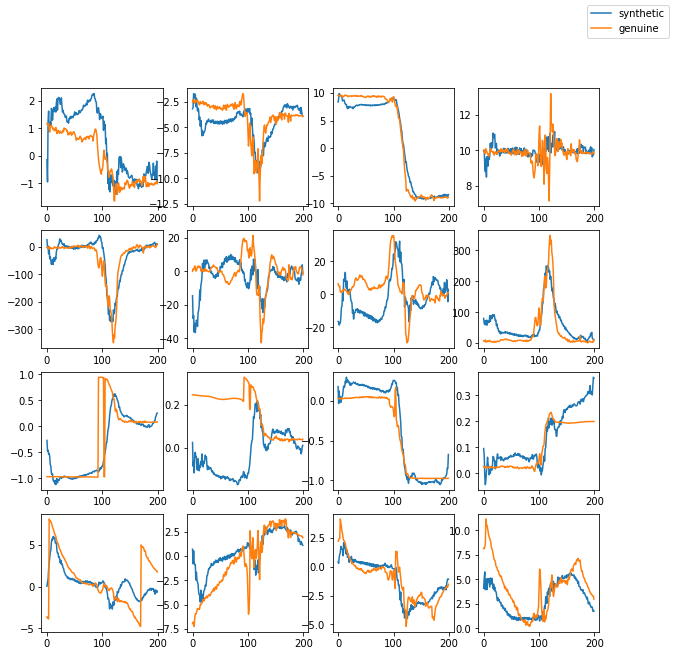

In [78]:
#vae = VAE(None, None, None)
#vae.load_model(f"no_0", f"specific_model")
#auth_user = 0
#print(auth_user)

real_gestures_allowed_per_terminal = 1
gestures_to_generate = 500

real_gesture_list = []

for terminal_type in [3,4,5,6,7,8,9]:
    
    legal_gestures = x_data[(train_gesture_map==1) & (y_user.argmax(axis=1) == auth_user) & (y_gesture.argmax(axis=1) == terminal_type) ]
    
    real_gesture_list.append(legal_gestures[:real_gestures_allowed_per_terminal])
    
real_gestures = np.concatenate(real_gesture_list)

#real_gestures = np.repeat(real_gestures, 1 + gestures_to_generate // (7 * real_gestures_allowed_per_terminal), axis=0)[:gestures_to_generate]



enc = vae.encoder.predict(scaler.transform(real_gestures))[2]

convex_hull_points = []

print(enc.shape)

for i in range(gestures_to_generate - (7*real_gestures_allowed_per_terminal)): 
    s = (np.random.pareto(3, 7))
    s = s / sum(s)
    
    new_point = np.dot(enc.transpose(), s)

    convex_hull_points.append([new_point])
    
convex_hull_points = np.concatenate(convex_hull_points)

enc = np.concatenate([enc, convex_hull_points])

dec = scaler.inverse_transform(vae.decoder.predict(enc))


fig, ax = plt.subplots(4,4, figsize=(10,10))


for i in range(16):
    if i == 0 :
        ax[divmod(i, 4)].plot(dec[0,:,i], label="synthetic")
        ax[divmod(i, 4)].plot(real_gestures[0,:,i], label="genuine")
    else:
        ax[divmod(i, 4)].plot(dec[0,:,i])
        ax[divmod(i, 4)].plot(real_gestures[0,:,i])        
    
fig.legend()
plt.show()
    

np.save(f"data/generated_samples/{auth_user}_limited_data_extra_data_self_mixed.npy", dec)


In [36]:
print(auth_user)

filtered = x_data[(train_gesture_map==1) & (y_user.argmax(axis=1) == auth_user) ]

random_indices = np.random.choice(range(len(filtered)), 100, replace=True)

print(filtered[random_indices].shape)

enc = vae.encoder.predict(filtered[random_indices])
mixed_enc = 0.5 * (enc[2] + np.roll(enc[2], 1,axis=0))

dec = vae.decoder.predict(mixed_enc)

print(dec.shape)

for i in range(16):
    plt.plot(reverse_custom_scaler(dec,scalers)[0,:,i])
    plt.plot(filtered[random_indices][0,:,i])
    plt.show()
    

np.save(f"data/generated_samples/{auth_user}_mixed.npy", dec)
    


0
(100, 200, 16)
4/4 [==============================] - 0s 23ms/step
(100, 200, 16)


NameError: name 'reverse_custom_scaler' is not defined

NameError: name 'random' is not defined

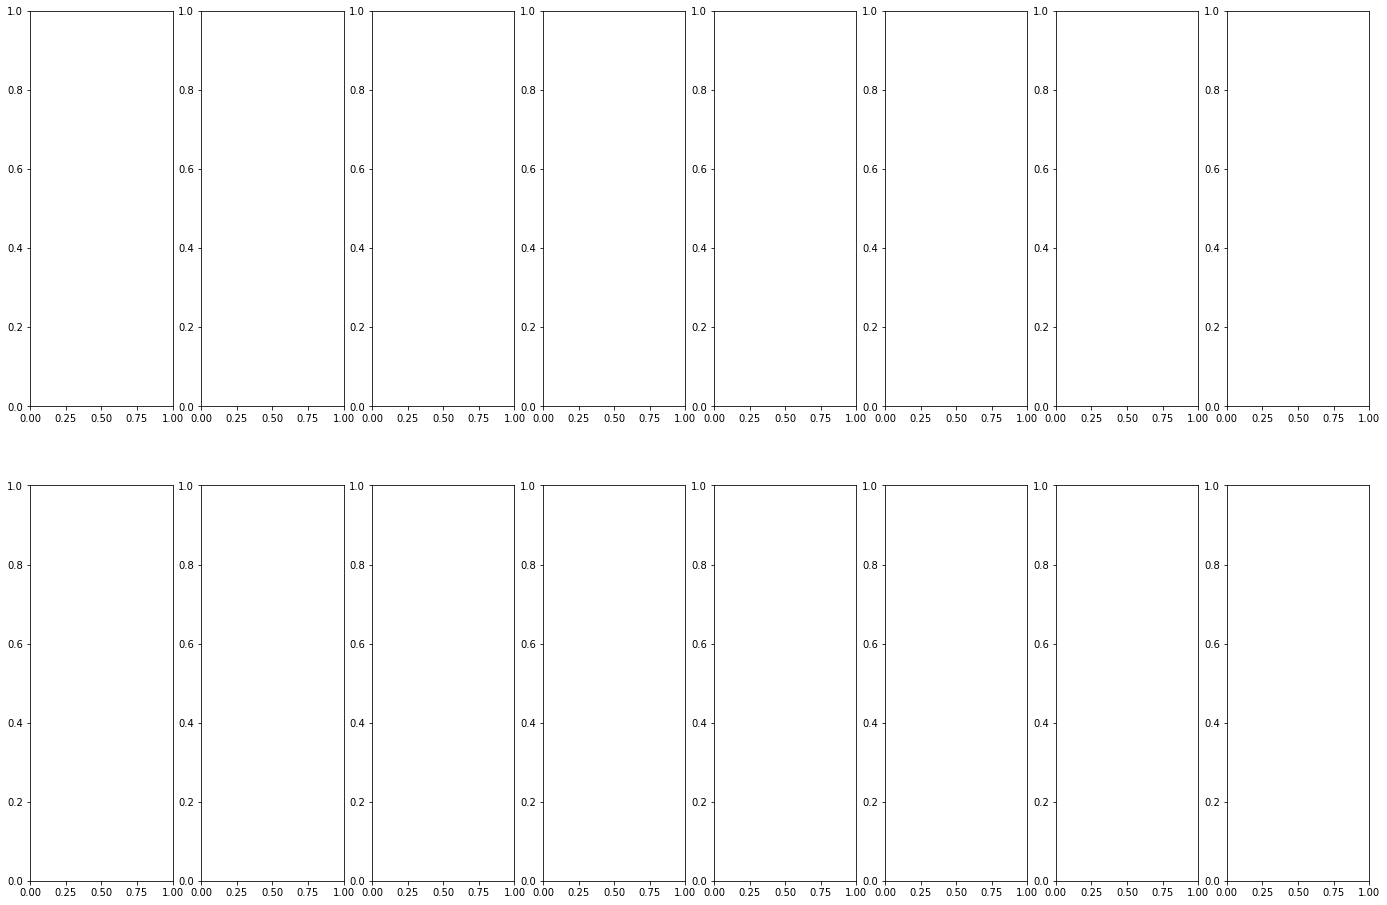

In [37]:
fig,ax = plt.subplots(2,8, figsize=(24,16))

filtered = x_data[y_intent==1]

for i in random.sample(range(0, len(filtered)), 1):
    for k in range(4):
        enc = vae.encoder.predict(filtered[i:i+1])
        dec = vae.decoder.predict(enc[2])
        for j in range(16):
            ax[divmod(j,8)].plot(dec[0,:,j])
            ax[divmod(j,8)].plot(dec[0,:,j])
    for j in range(16):
        ax[divmod(j,8)].plot(filtered[i,:,j], color="blue")
        

plt.show()

1/1 [==============================] - 0s 32ms/step


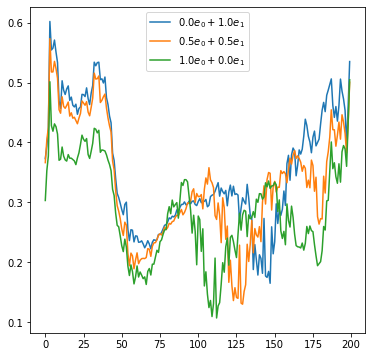

In [39]:
filtered = x_data[y_intent==1]
embeddings = []

plt.figure(figsize=(6,6))

for i in range(1,3):
    
    _, _, enc = vae.encoder.predict(scaler.transform(filtered[i:i+1]))
    dec = vae.decoder.predict(enc)
    
    embedding = [pca.transform(enc)[0][0], pca.transform(enc)[0][1]]
    embeddings.append(enc)


_n = 2
for j in range(0, _n + 1):
    w1 = j / _n
    w2 = 1 - w1
    
    new_embedding = (embeddings[0] * w1 + embeddings[1] * w2)

    dec = vae.decoder.predict(new_embedding)

    plt.plot(dec[0,:,0], label = f"${round(w1,1)}e_0 + {round(w2,1)}e_1$")


plt.legend()

plt.show()

In [42]:
tf.reduce_mean(abs(classifier(x_data[:1]) - y_intent[:1]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.00034093857>

In [88]:
y_intent[:1]

array([1], dtype=int32)

In [89]:
classifier(x_data[:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.6278042e-22]], dtype=float32)>

In [84]:
arr1, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == 0)])
arr2, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == 1)])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


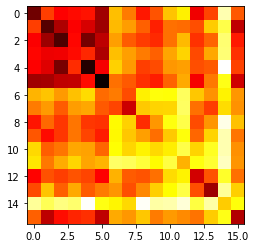

In [35]:
from random import randint

def average_dist(x, y):
    total = 0
    n = 1000
    for u in range(n):
        vx = np.array(x[randint(0, len(x)-1)])
        vy = np.array(y[randint(0, len(y)-1)])
        total += (sum((vx-vy)**2)**0.5)
    return total / n


a = np.zeros((16, 16))




for i in range(16):
    print(i)
    for j in range(i, 16):
        arr1, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == i)])
        arr2, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == j)])
        
        #print(f"User {i} compared to {j} : {average_dist(arr1, arr2)}")
        a[i,j] = average_dist(arr1, arr2)
        a[j,i] = average_dist(arr1, arr2)

plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

#arr1, _, _ = vae.encoder(x_data[(y_intent == 0) & (y_user.argmax(axis=1) == 3)])
#arr2, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == 3)])
#average_dist(arr1, arr2)




In [118]:
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

14.229895016786097